<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/Market_Analysis_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install kneed
!pip install alpaca-trade-api
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Market Analysis for Paper Trading




0.   Connect to the market data provider api
1.   Get Data
2.   Filter available assets in Alpaca Market
3.   Find Cointegrated pairs for Statistical Arbitrage
4.   Pick cointegrated pairs and detect trend with HMM Clustering
5.   Detect entry point, target price and stop price by the chart
6.   Create trading report.



#### Imports

In [30]:
import random
from datetime import datetime
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from pandas_datareader.nasdaq_trader  import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learing related imports
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# cointegration and statistic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# market data
import alpaca_trade_api as alpaca
import yfinance as yf

#### Connect to the market data provider

In [31]:
# key_id and secret_key

In [32]:
api = alpaca.REST(key_id, secret_key, 'https://paper-api.alpaca.markets')
# api.get_account()

#### Get Data

In [33]:
# get list of available stocks 
asset_list =api.list_assets()
asset_list = [asset.symbol for asset in asset_list if (asset.status == 'active') and (asset.tradable == True) and (asset.shortable == True) and (asset.fractionable == True)]
len(asset_list), asset_list[:10]
asset_list = random.sample(population=asset_list, k=200)
len(asset_list)

200

In [34]:
today = datetime.today().strftime('%Y-%m-%d')
today

'2023-01-02'

In [35]:
start_date = '2020-01-01'
end_date = today
data = yf.download(asset_list, start_date, end_date)
data = data['Adj Close']

[*********************100%***********************]  200 of 200 completed


#### Clear Data

In [36]:
data.dropna(inplace=True, axis=1)
data = data.iloc[100:400]
data.head()

ABB       ABCB       AGYS    AIR         AL       AMPH  \
Date                                                                       
2020-05-27  18.531410  25.612299  20.100000  21.27  28.985561  18.790001   
2020-05-28  18.645100  23.743839  19.430000  20.74  28.966494  18.620001   
2020-05-29  18.626150  23.216833  19.230000  20.17  28.709055  18.639999   
2020-06-01  18.796686  23.053946  20.129999  20.08  29.767412  19.049999   
2020-06-02  19.336712  22.718580  20.020000  20.57  30.415773  18.840000   

                   AMT       ANIK        AOR       ARKK  ...        WBS  \
Date                                                     ...              
2020-05-27  237.320084  34.970001  42.928535  61.021873  ...  27.248682   
2020-05-28  243.073898  34.180000  42.975914  60.279968  ...  26.489746   
2020-05-29  243.121002  33.529999  43.032780  61.324493  ...  25.877106   
2020-06-01  248.903122  33.910000  43.383408  63.257362  ...  26.059982   
2020-06-02  248.225067  34.840000  43.658226  64.038315  ...  25.831388   

                  WDS         WIX         WK         WMT       XNTK  \
Date                                                                  
2020-05-27  13.334732  205.960007  43.310001  117.780418  89.129456   
2020-05-28  13.222167  207.399994  43.560001  118.943977  88.508308   
2020-05-29  13.066306  222.330002  44.540001  119.299782  90.391472   
2020-06-01  13.516569  220.970001  45.020000  119.203613  90.618263   
2020-06-02  13.585840  228.190002  44.450001  119.184402  91.466141   

                  XPH       YETI       YOLO       ZYXI  
Date                                                    
2020-05-27  41.985699  33.750000  10.361492  16.588778  
2020-05-28  42.005138  31.980000  10.389698  17.020357  
2020-05-29  41.966278  32.099998  10.107625  17.442945  
2020-06-01  41.771988  32.200001  10.229857  17.712681  
2020-06-02  41.907990  33.189999  10.286272  17.595795  

[5 rows x 184 columns]

In [37]:
data.value_counts().isnull().sum()

0

#### Feature Engineering

In [38]:
# create dataframe which cointains return and volatility information
df_extended = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_extended['volatility'] = data.pct_change().std() * np.sqrt(255)
df_extended.head()

returns  volatility
ABB   0.597442    0.232461
ABCB  0.649684    0.484654
AGYS  1.022285    0.549967
AIR   0.591942    0.582439
AL    0.424702    0.497656

In [39]:
# df_extended = df_extended.fillna(method="ffill")
# df_extended.isnull().any()
# df_extended = df_extended.replace([np.inf, -np.inf], 0)

In [40]:
# scaling the data
scaler = StandardScaler()
scaler = scaler.fit_transform(df_extended)
df_scaled = pd.DataFrame(scaler, index=df_extended.index, columns=df_extended.columns)
df_scaled.head()

returns  volatility
ABB   0.311454   -0.849025
ABCB  0.439437    0.269827
AGYS  1.352239    0.559588
AIR   0.297981    0.703646
AL   -0.111726    0.327510

#### K-Means Clustering

In [41]:
# find the optimal number of clusters 
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"The optimal number of clusters: {c}")

The optimal number of clusters: 4


In [42]:
# fit the model
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
preds = kmeans.predict(df_scaled)

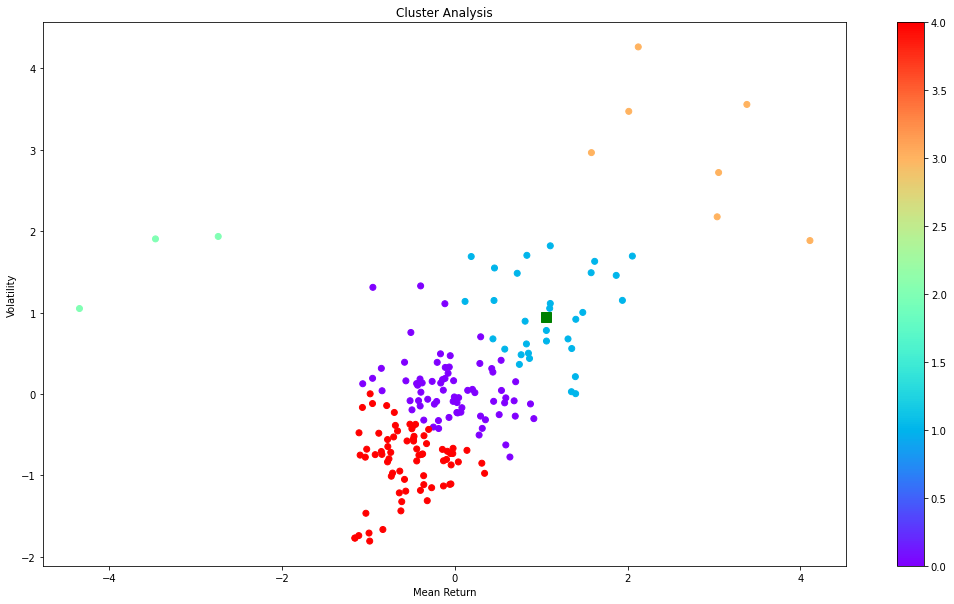

In [69]:
# show results
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=kmeans.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0][1], centroids[:,1][1], "sg", markersize=10)
plt.show()

In [66]:
centroids[:,1]

array([ 0.056703  ,  0.95156028,  1.63120615,  3.00662637, -0.82589285])

In [44]:
# return the clustered series
clustered_series = pd.Series(index=X.index, data=kmeans.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series

ABB     4
ABCB    0
AGYS    1
AIR     0
AL      0
       ..
XNTK    4
XPH     4
YETI    1
YOLO    0
ZYXI    0
Length: 184, dtype: int32

In [45]:
clustered_df = pd.DataFrame(clustered_series)
clustered_df.value_counts()

4    72
0    71
1    31
3     7
2     3
dtype: int64

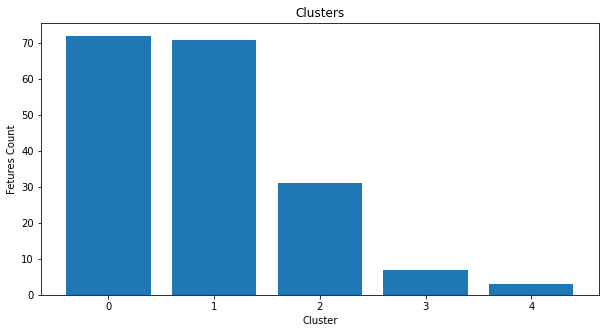

In [46]:
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Fetures Count")
plt.show()

In [47]:
# if there any significant outliers can be detected it should remove from the dataset, but at this point it has been worked with small kind of test dataset which not contains it.
clustered_series_rem_ol = clustered_series[clustered_series < 3]

#### Calculate Cointegration

In [48]:
def calculate_cointegration(series_1, series_2):
  coint_flag = 0
  coint_result = coint(series_1, series_2)
  coint_t = coint_result[0]
  p_value = coint_result[1]
  critical_value = coint_result[2][1]

  model = simplefilter.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
  return coint_flag, hedge_ratio

In [49]:
# loop through and calculate cointegrated pairs
tested_pairs = []
cointegrated_pairs = []

for base_asset in clustered_series_rem_ol.index:
  base_label = clustered_series_rem_ol[base_asset]

  for compare_asset in clustered_series_rem_ol.index:
    compare_label = clustered_series_rem_ol[compare_asset]

    test_pair = base_asset + compare_asset
    test_pair = ''.join(sorted(test_pair))
    is_tested = test_pair in tested_pairs
    tested_pairs.append(test_pair)

    if compare_asset != base_asset and base_label == compare_label and not is_tested:
      series_1 = data[base_asset].values.astype(float)
      series_2 = data[compare_asset].values.astype(float)
      coint_flag, _ = calculate_cointegration(series_1, series_2)
      if coint_flag == 1:
        cointegrated_pairs.append({
            "base_asset": base_asset,
            "compare_asset": compare_asset,
            "label": base_label
        })

df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
df_coint.head()

base_asset compare_asset  label
0         ABCB          BKNG      0
255       HONE          NSIT      0
254       HONE          LFCR      0
253       HONE          HTBI      0
245       GMED           TGT      0

In [50]:
df_coint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 130
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   base_asset     390 non-null    object
 1   compare_asset  390 non-null    object
 2   label          390 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 10.7+ KB


In [70]:
df_coint = df_coint[df_coint['label'] == 1 ]

In [78]:
df_coint.values

array([['HOUS', 'YETI', 1],
       ['HSC', 'HWC', 1],
       ['HSC', 'MFA', 1],
       ['HSC', 'NDLS', 1],
       ['HSC', 'VHI', 1],
       ['CSTM', 'MFA', 1],
       ['HOUS', 'MFA', 1],
       ['CUK', 'ENVA', 1],
       ['CUK', 'HWC', 1],
       ['AGYS', 'MFA', 1],
       ['CUK', 'PK', 1],
       ['CUK', 'REVG', 1],
       ['STKL', 'SVC', 1],
       ['HWC', 'MFA', 1],
       ['HSC', 'YETI', 1],
       ['PK', 'SVC', 1],
       ['BALY', 'SVC', 1],
       ['HOUS', 'HSC', 1],
       ['BW', 'CUK', 1],
       ['BW', 'ENVA', 1],
       ['GILT', 'PK', 1],
       ['BW', 'SBNY', 1],
       ['MFA', 'YETI', 1],
       ['MFA', 'WK', 1],
       ['MFA', 'VHI', 1],
       ['MFA', 'SBNY', 1],
       ['HEAR', 'HOUS', 1],
       ['HEAR', 'HSC', 1],
       ['HEAR', 'HWC', 1],
       ['HEAR', 'MFA', 1],
       ['HEAR', 'MGY', 1],
       ['HEAR', 'NDLS', 1],
       ['HEAR', 'VHI', 1],
       ['NDLS', 'VHI', 1],
       ['ATRO', 'BW', 1],
       ['ATRO', 'SBNY', 1],
       ['AXTI', 'BALY', 1],
       ['AXTI'

In [107]:
from typing_extensions import dataclass_transform
def  plot_coint_assets(d, location): 
  asset_1 = d["base_asset"].iloc[location]
  asset_2 = d["compare_asset"].iloc[location]
  asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
  asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
  plt.figure(1, figsize=(20, 8))
  plt.plot(asset_1_values)
  plt.plot(asset_2_values)
  plt.legend([asset_1, asset_2])
  plt.show()

  series_1 = data[asset_1].values.astype(float)
  series_2 = data[asset_2].values.astype(float)
  coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
  spread = series_1 - (hedge_ratio *  series_2)
  plt.figure(1, figsize=(20, 8))
  plt.plot(spread)
  plt.show()


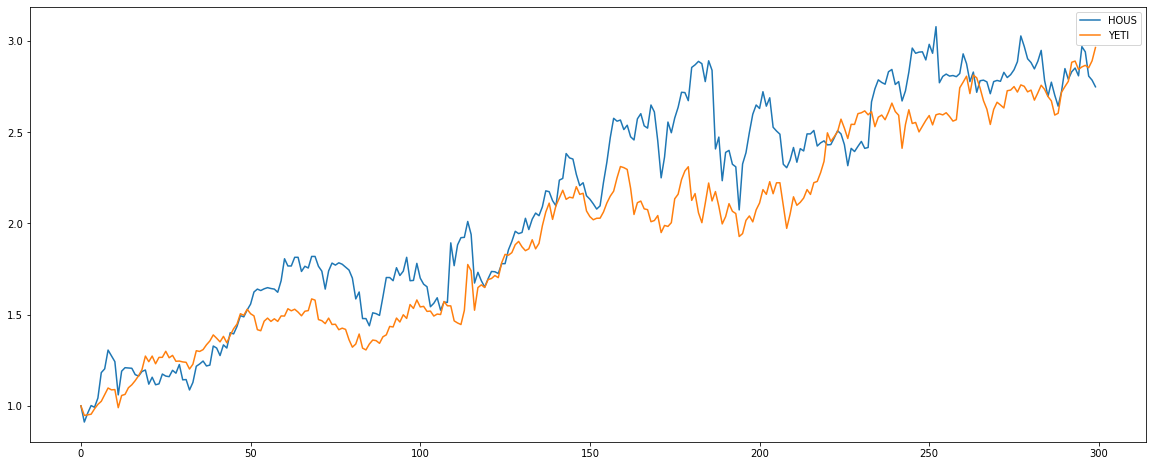

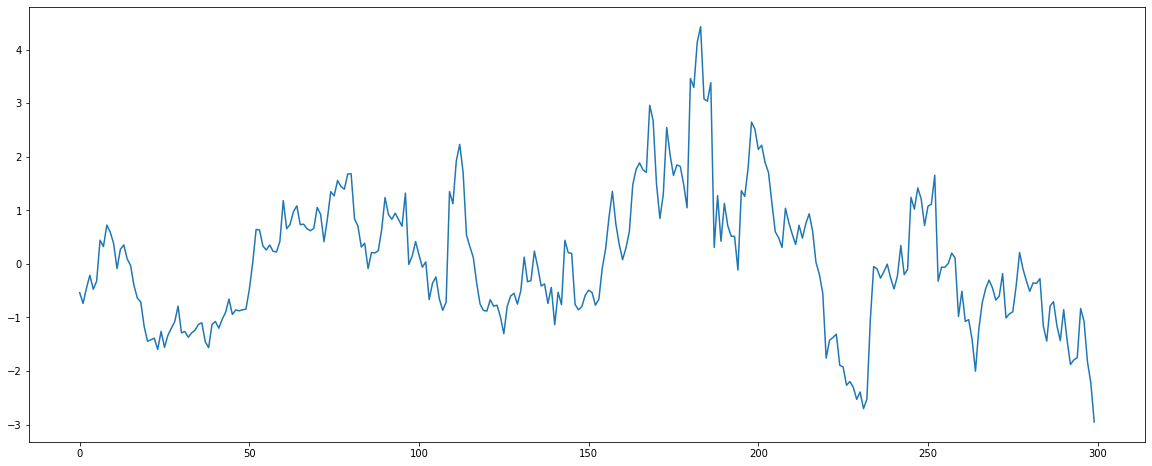

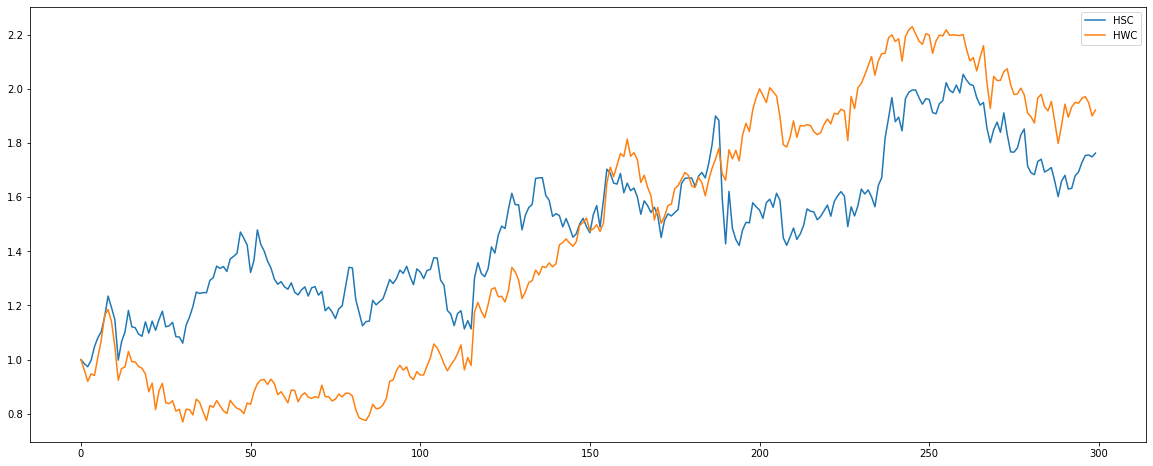

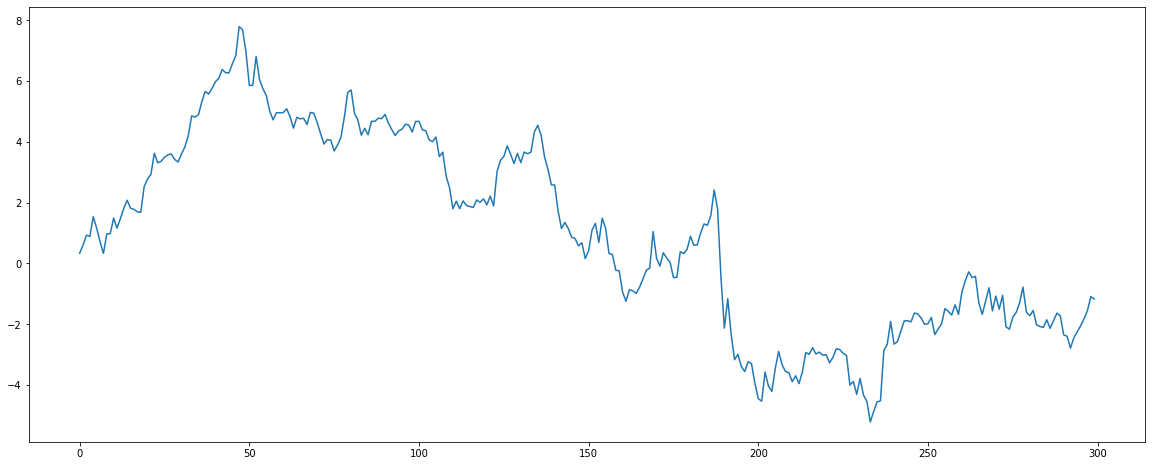

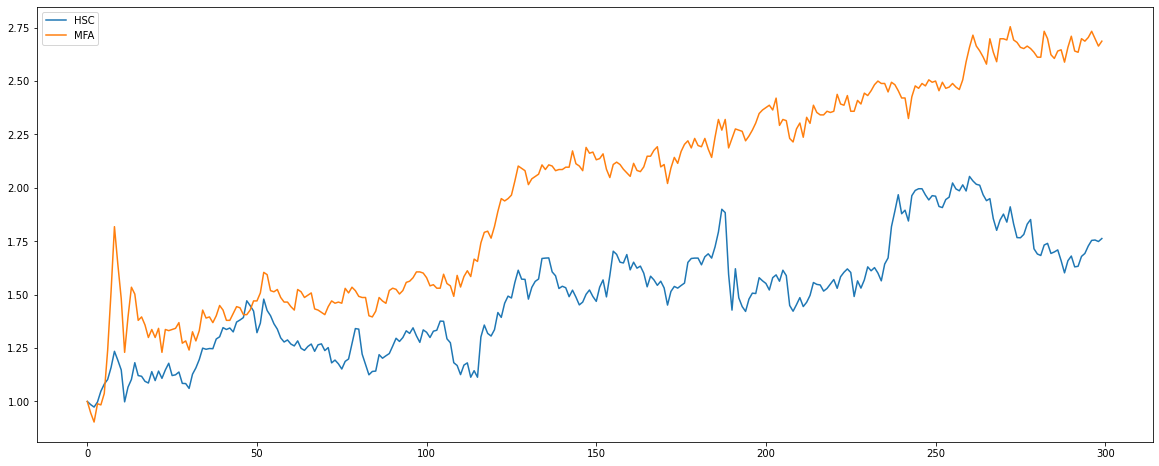

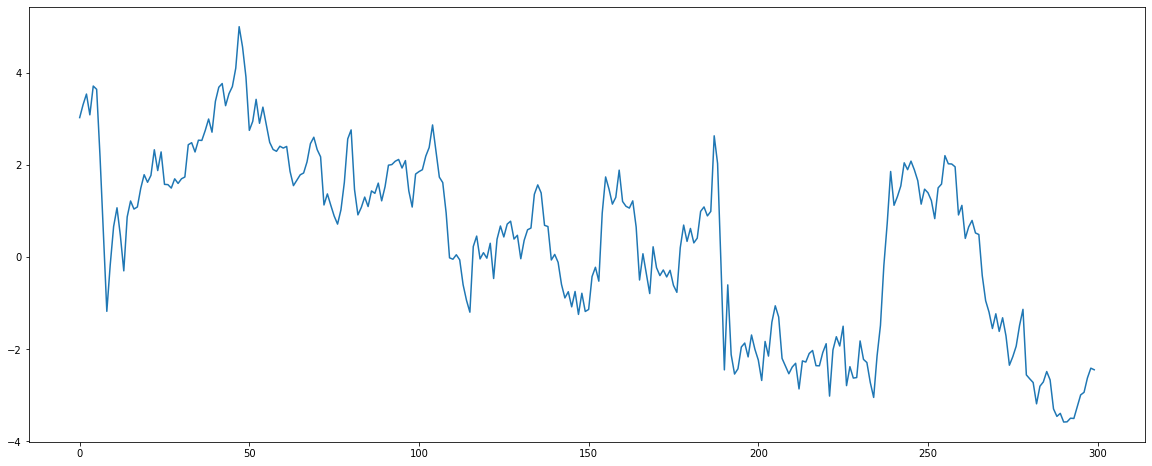

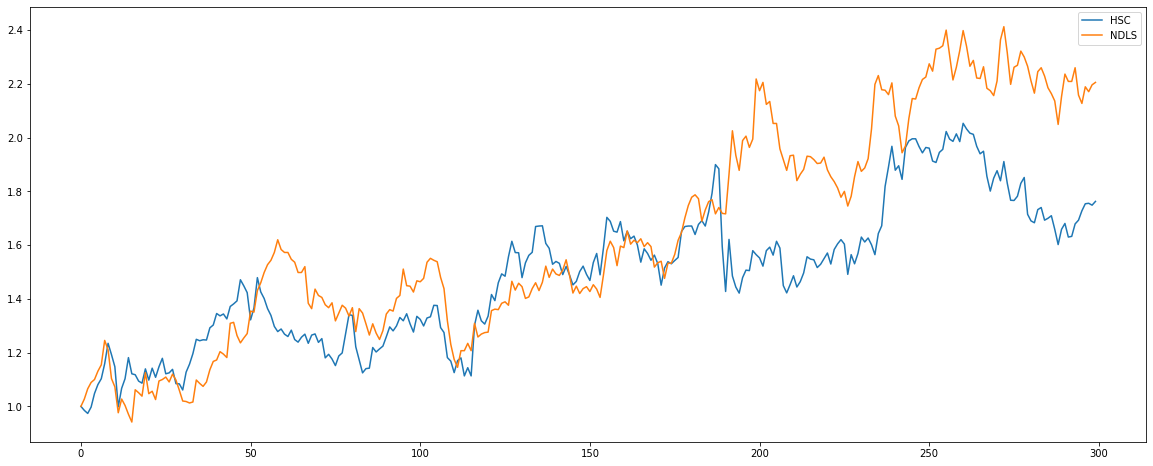

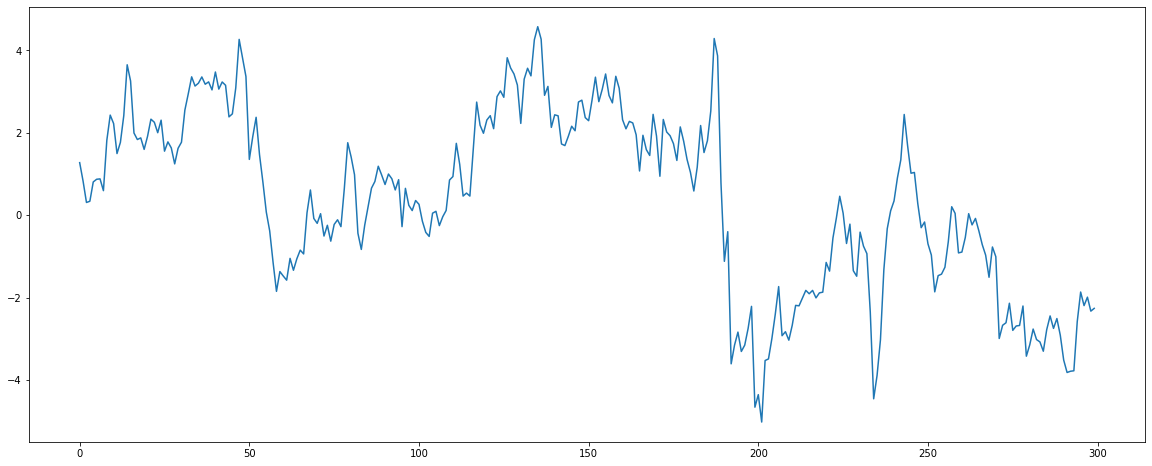

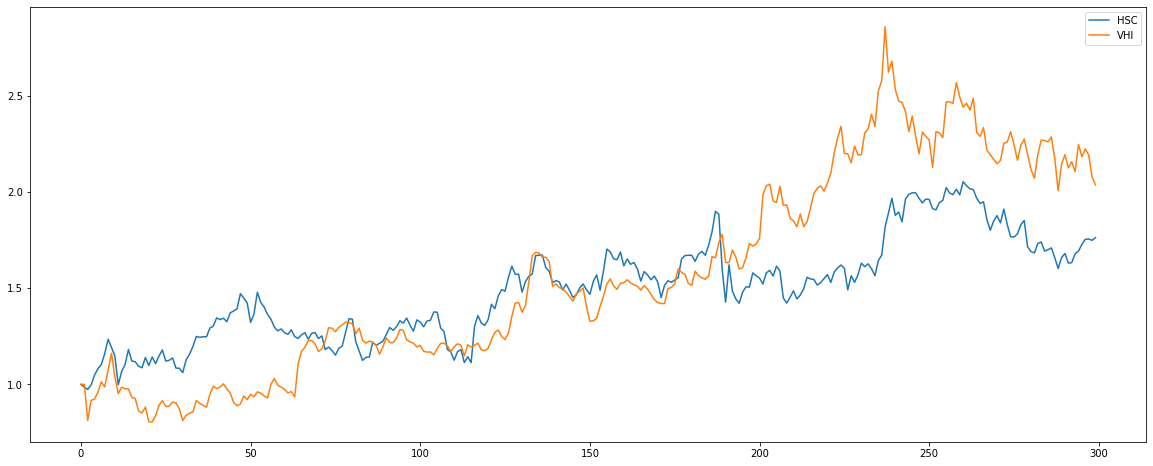

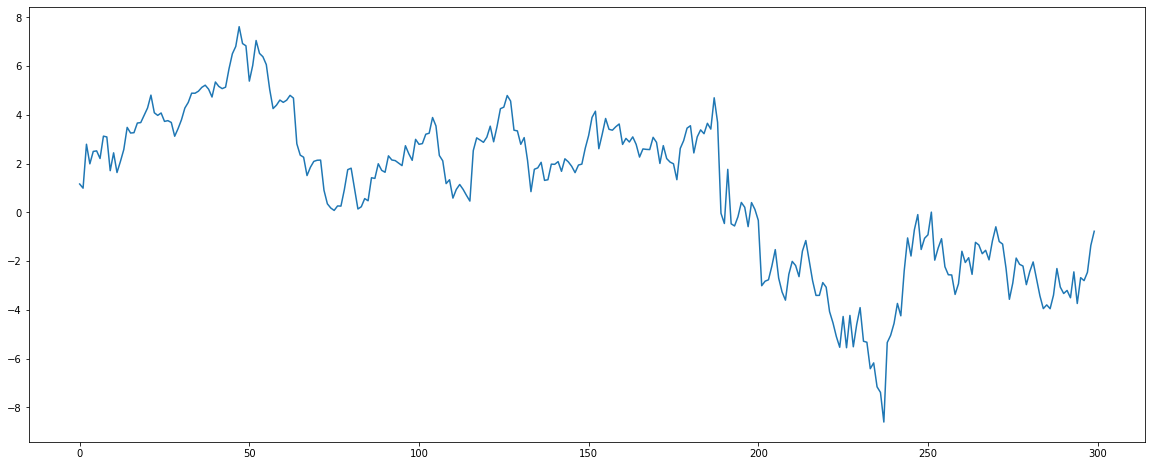

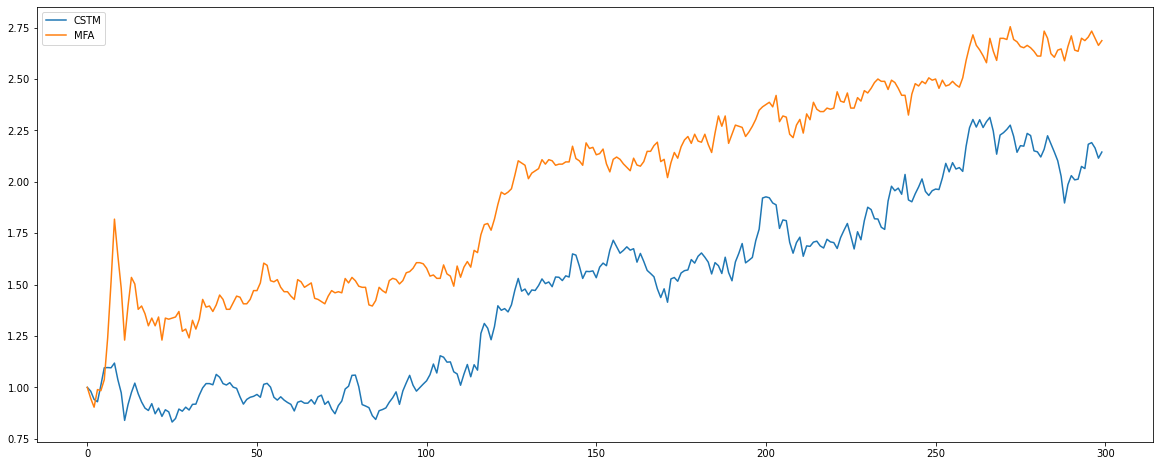

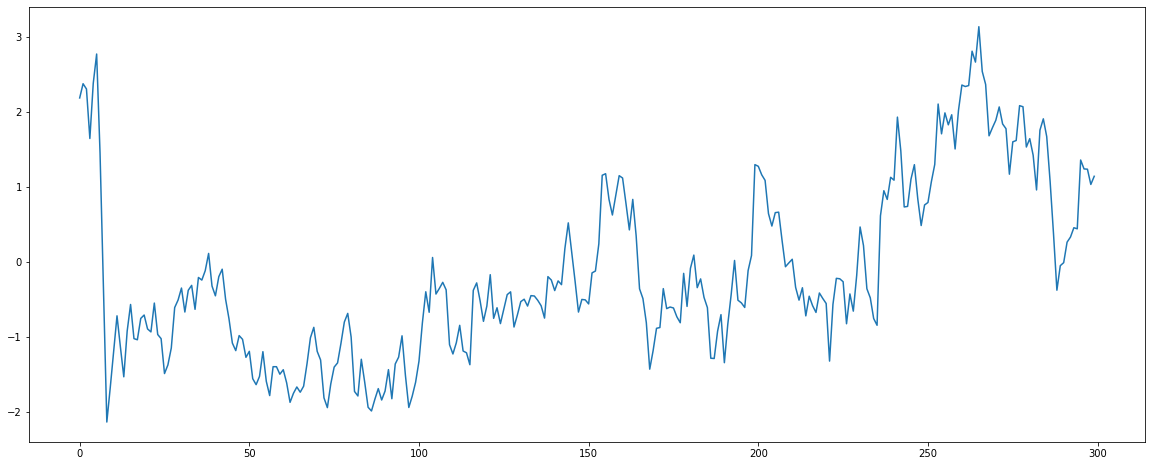

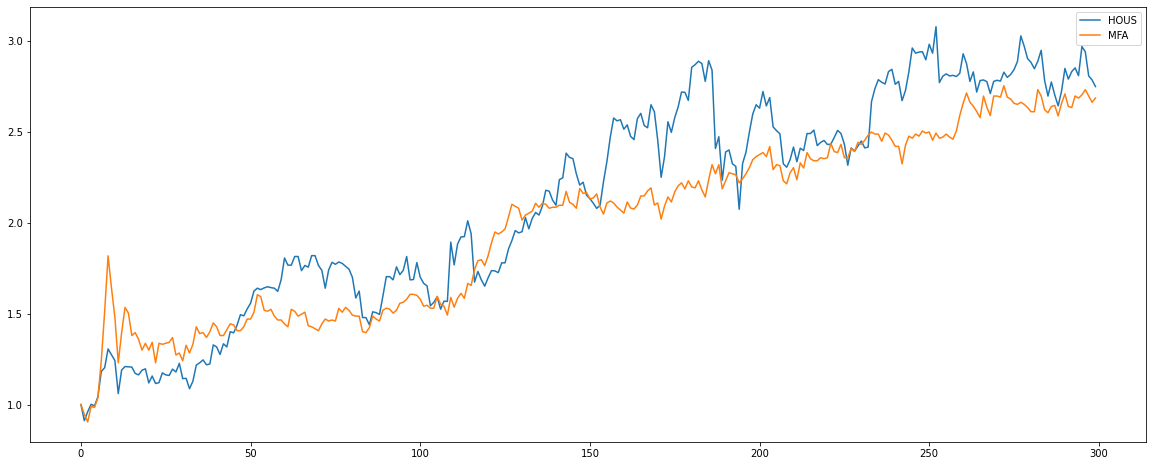

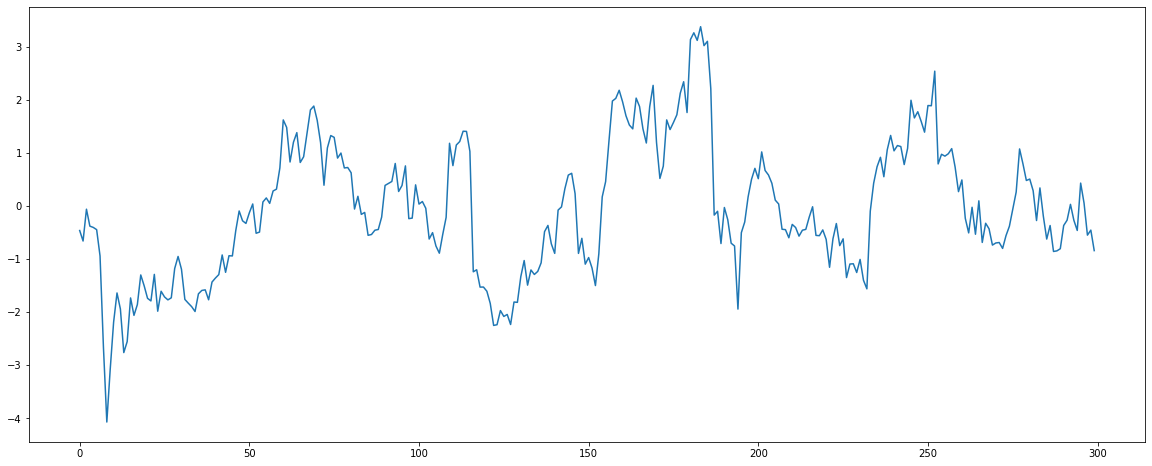

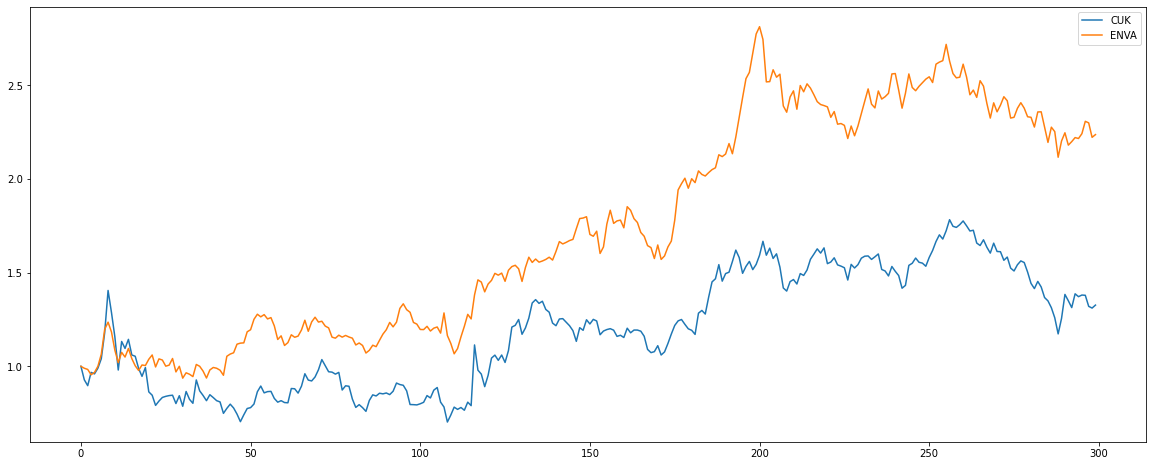

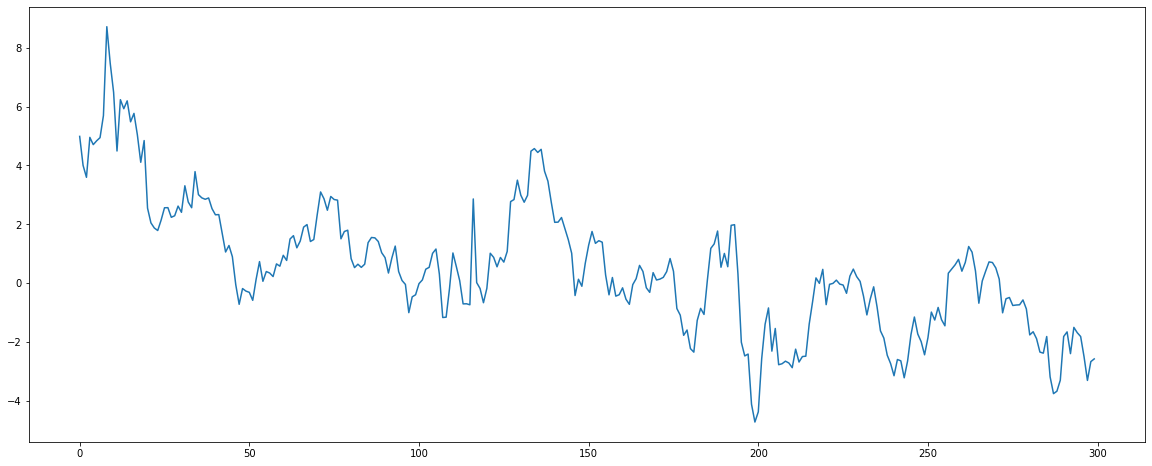

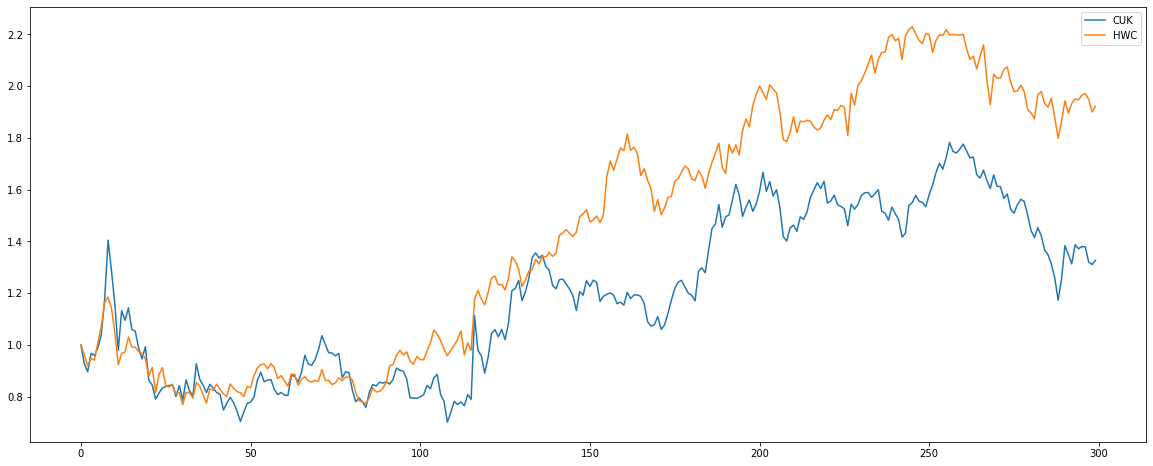

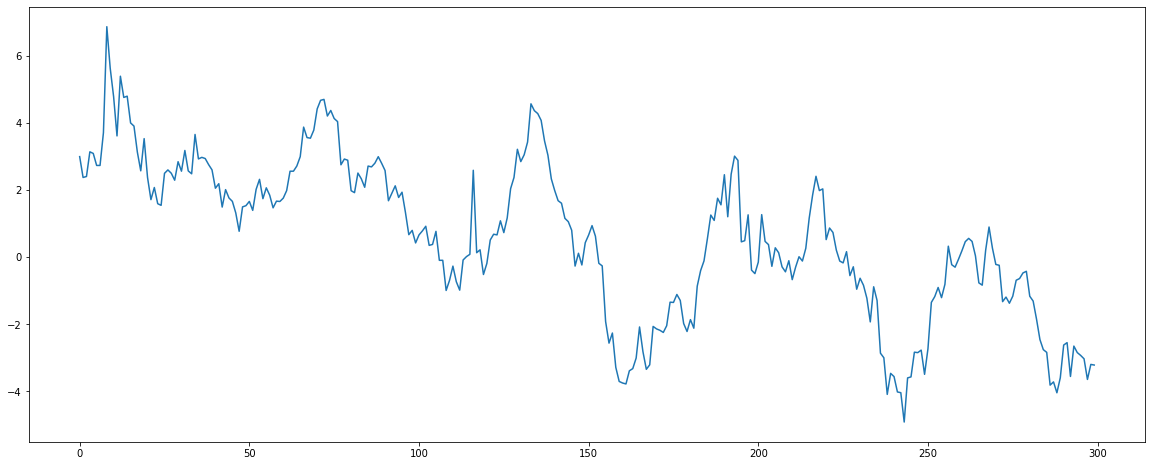

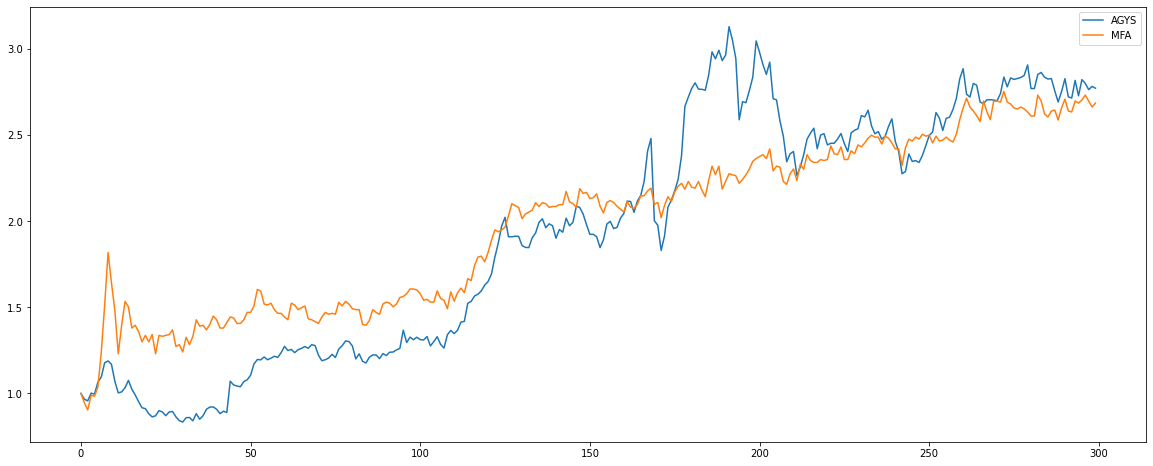

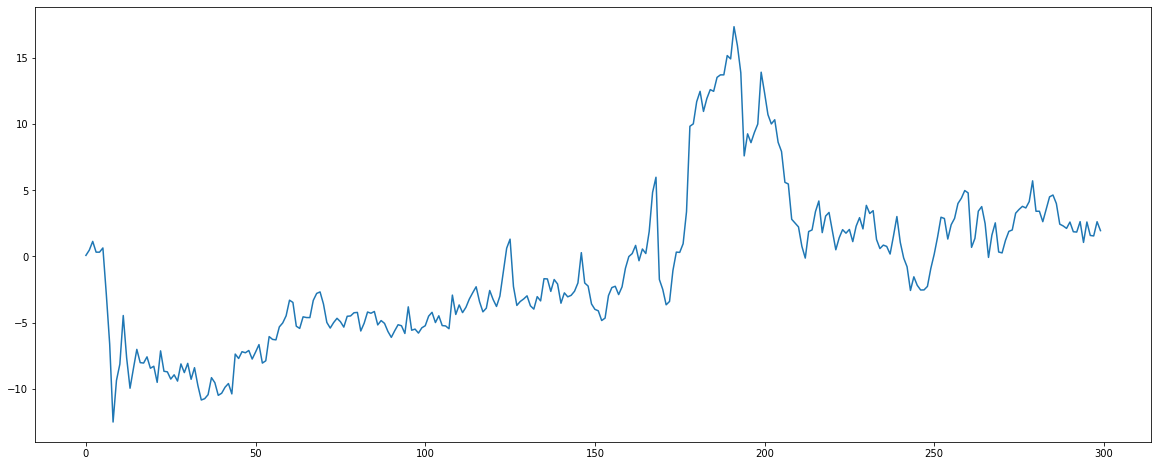

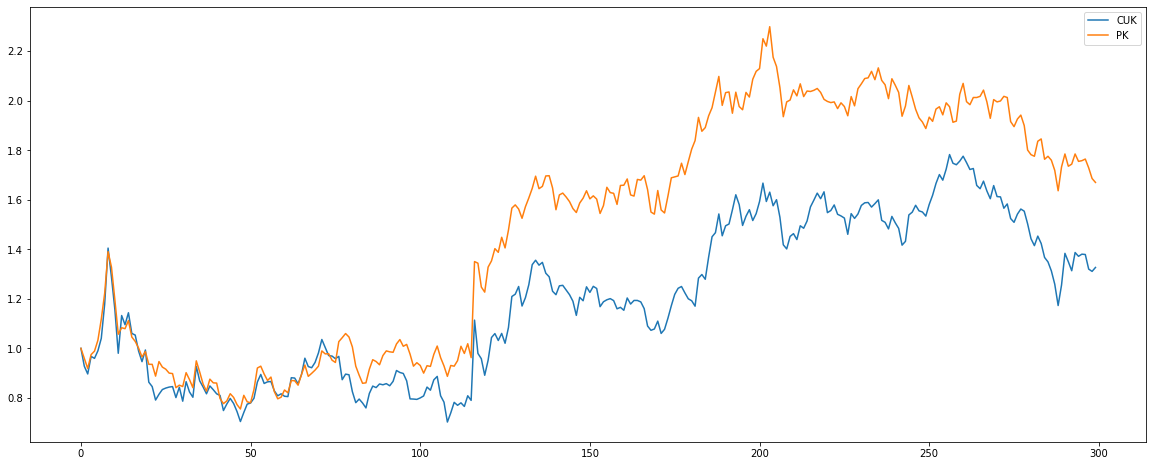

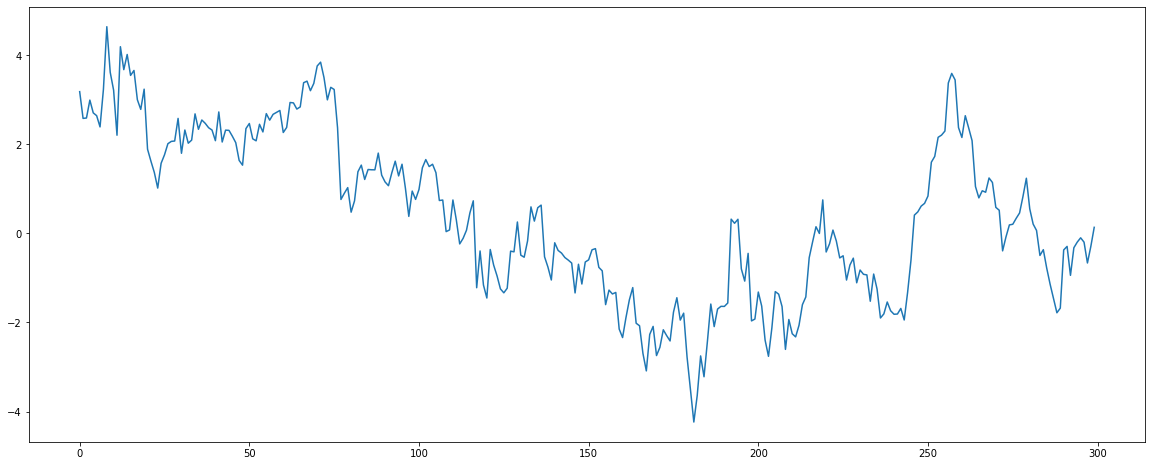

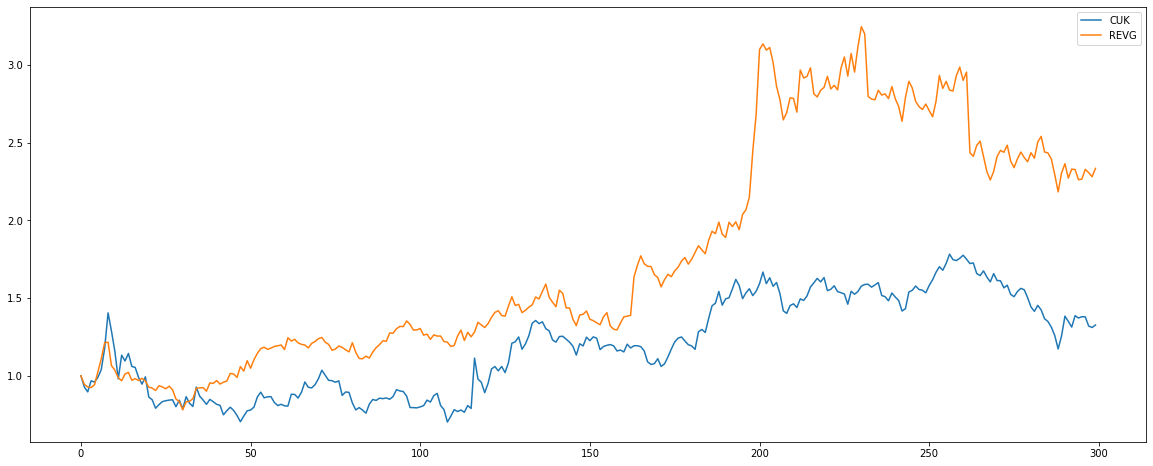

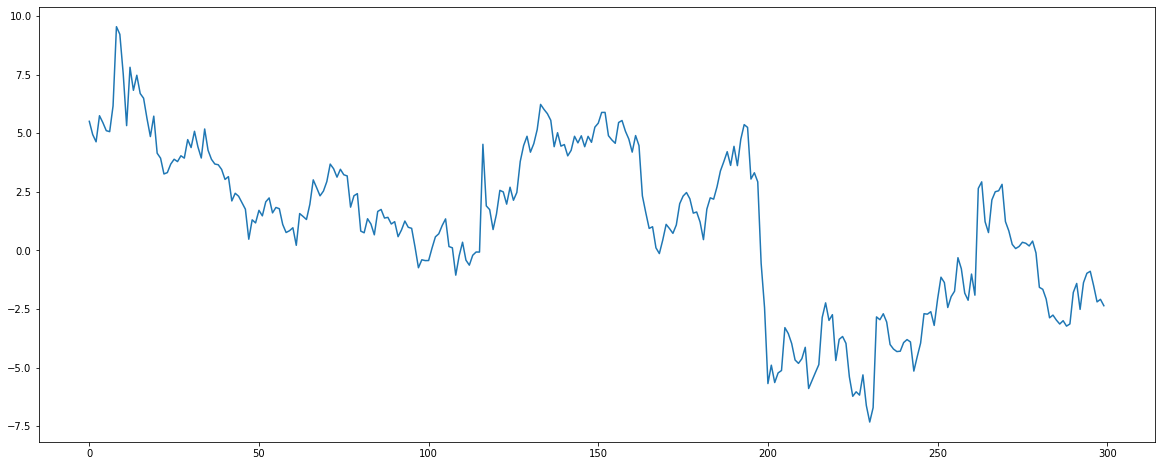

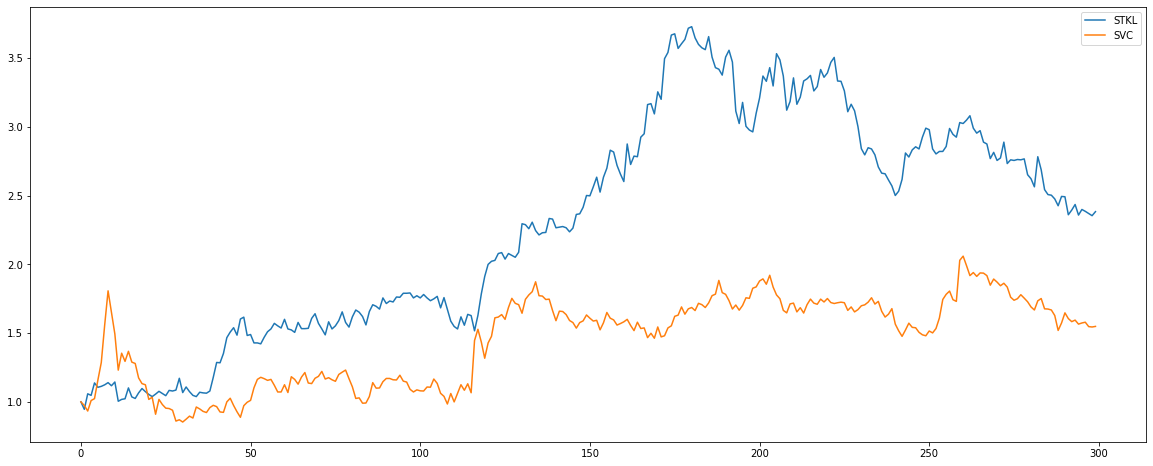

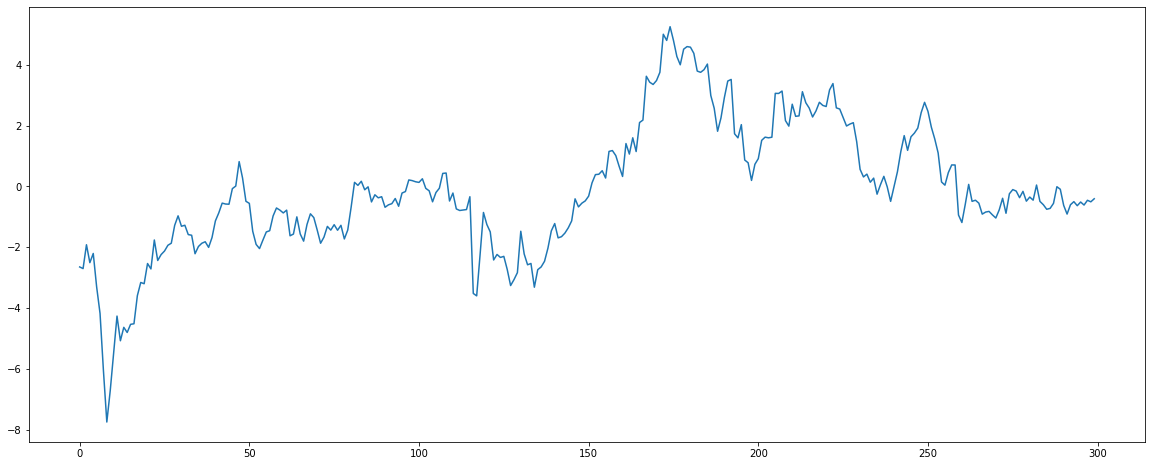

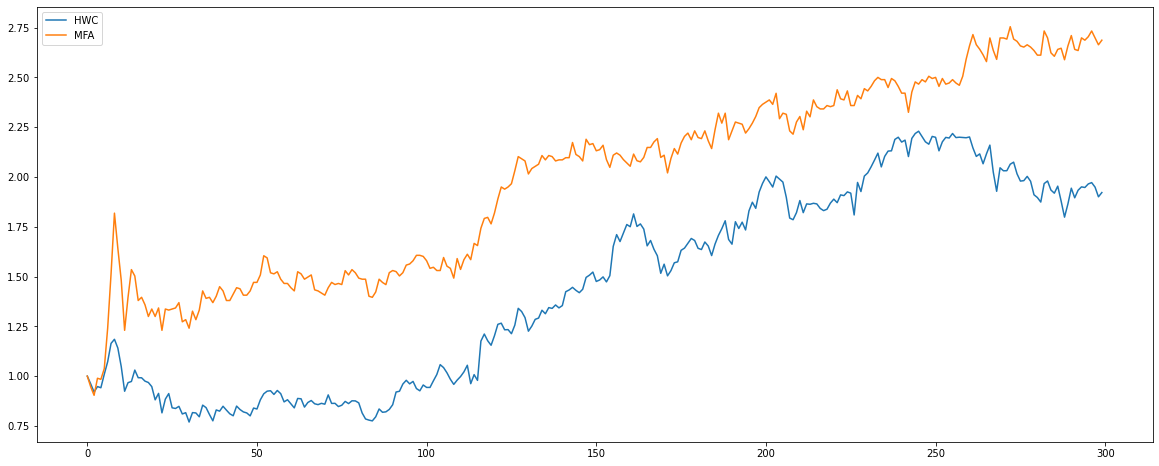

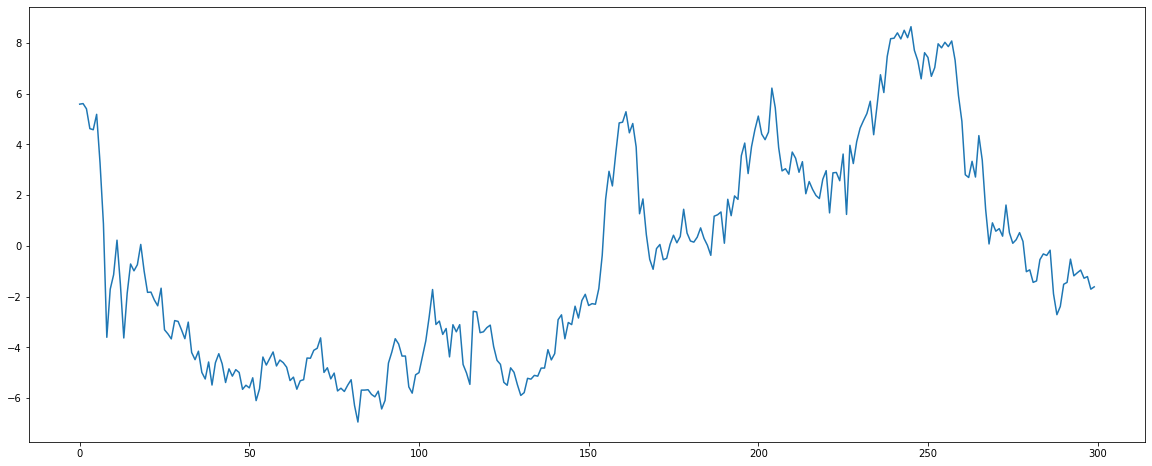

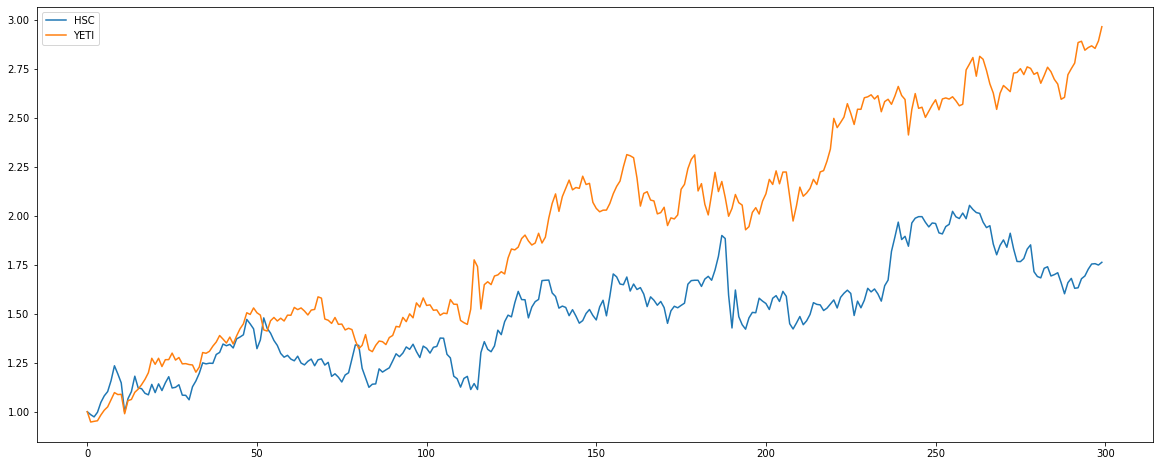

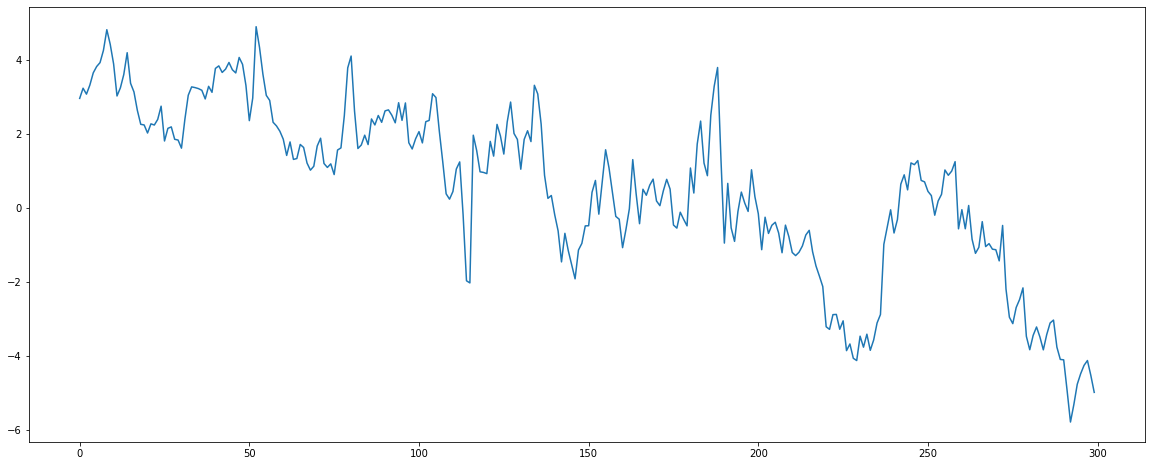

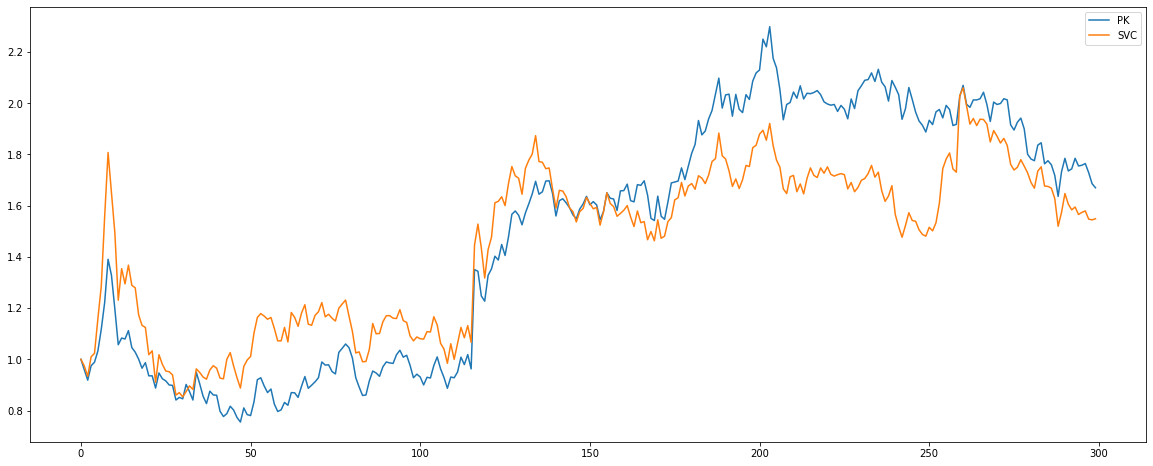

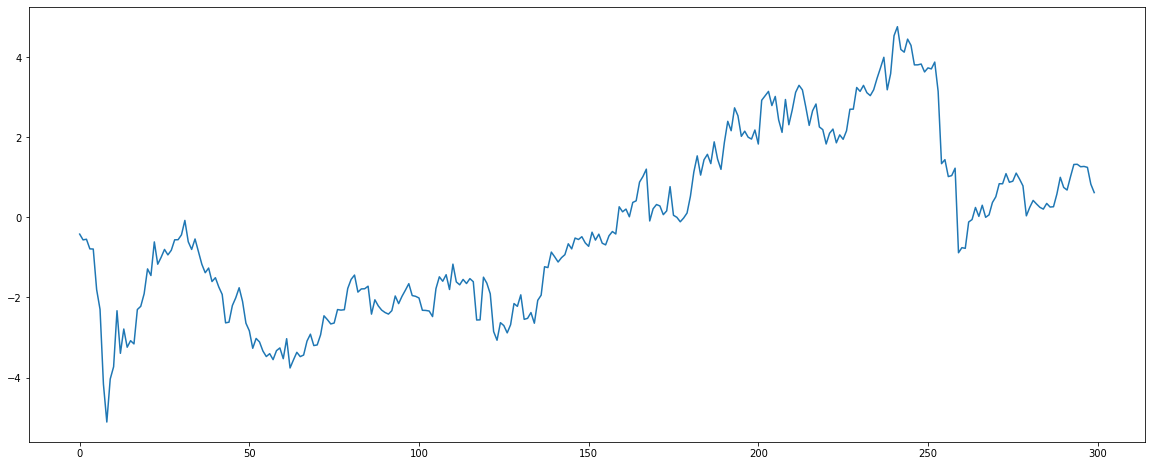

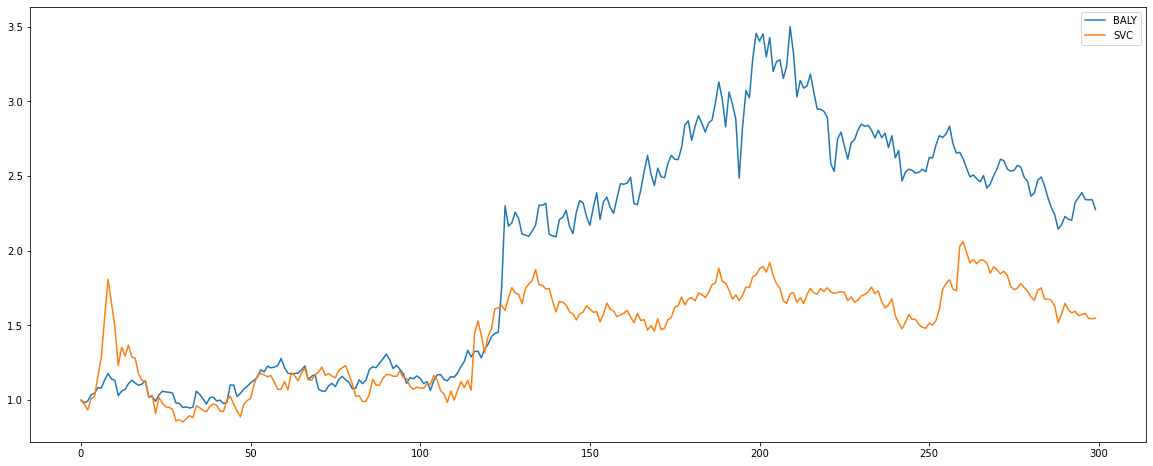

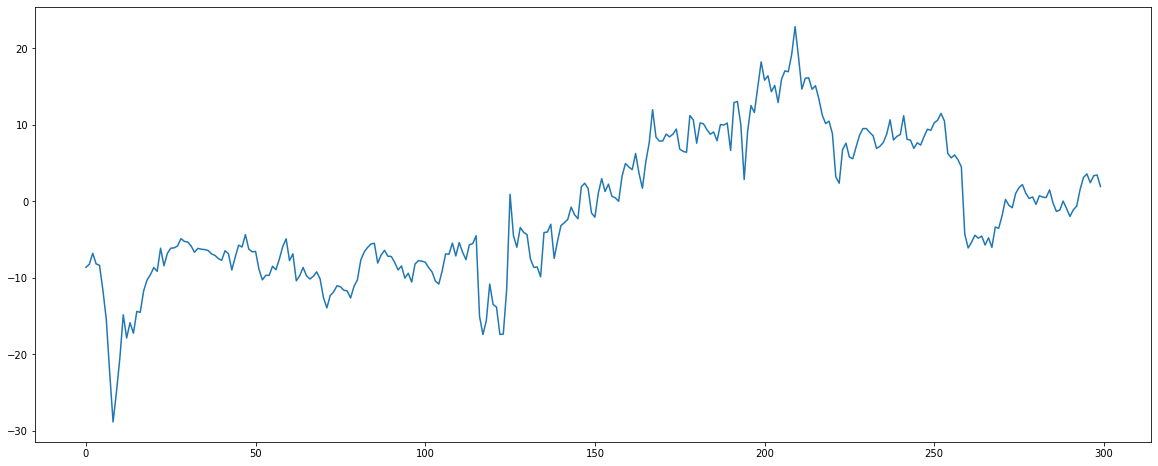

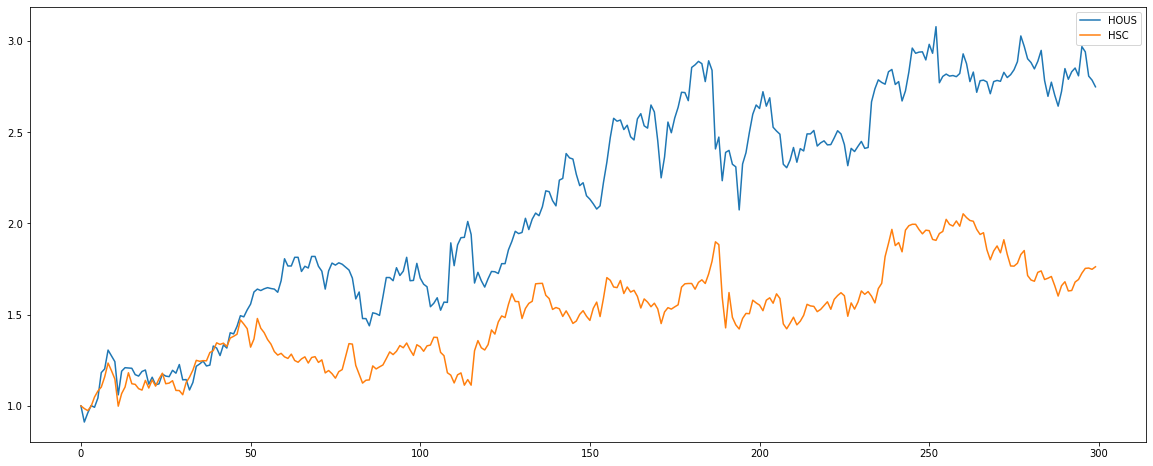

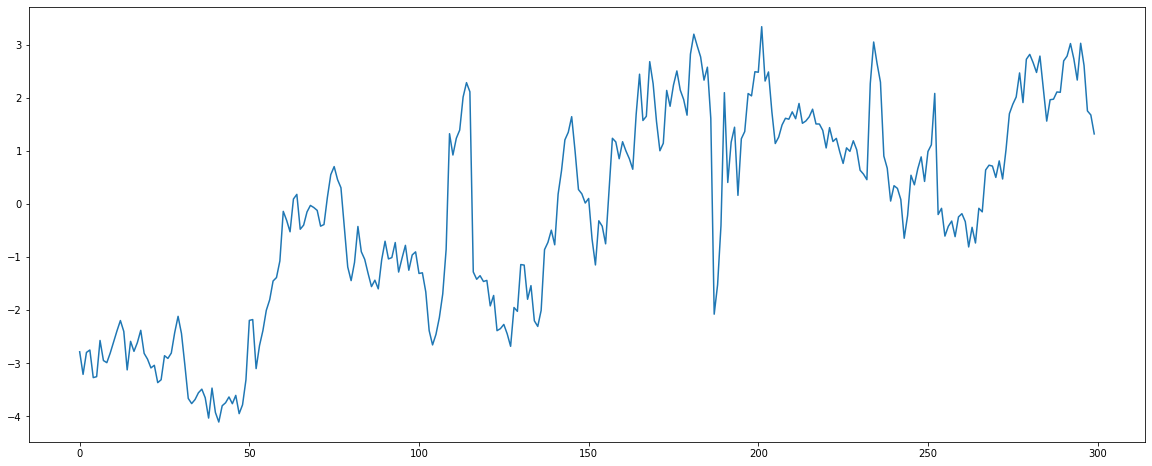

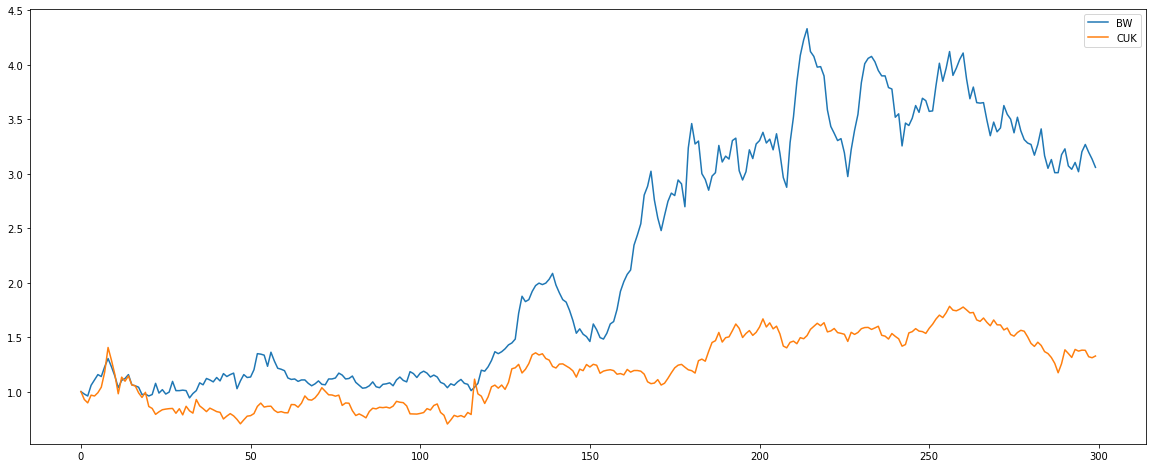

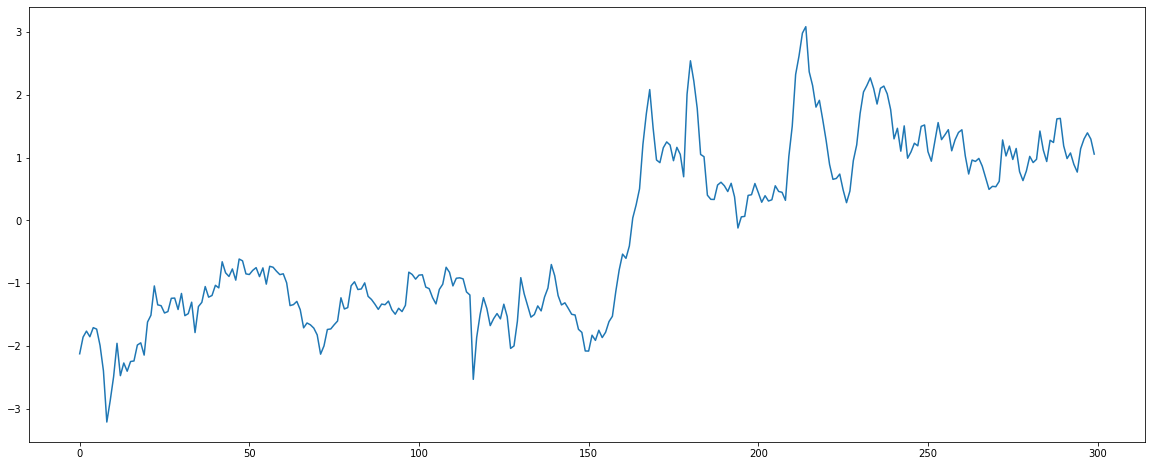

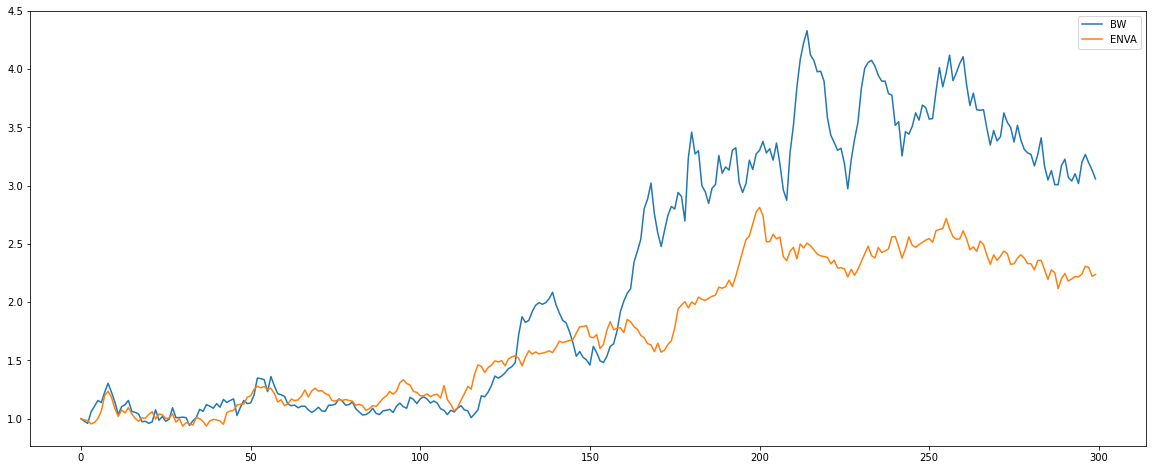

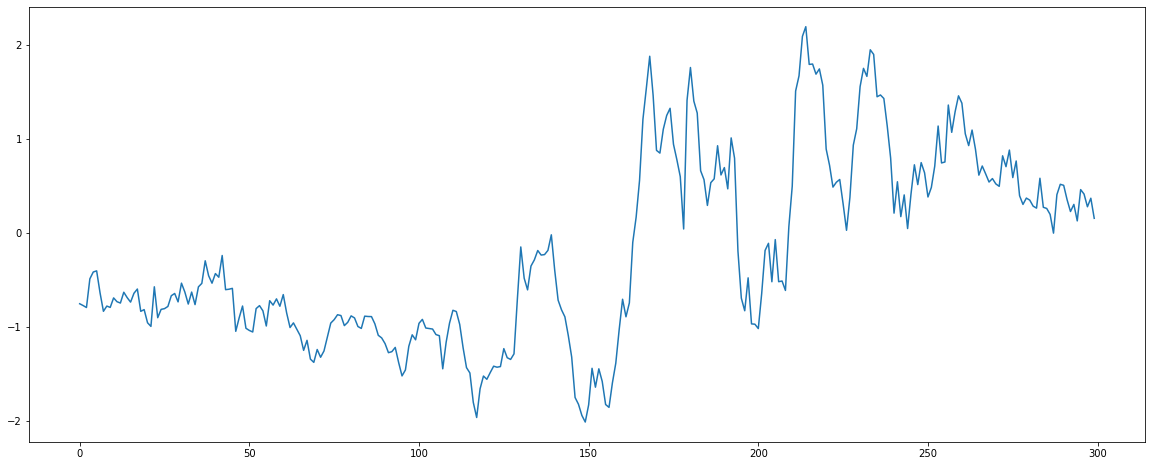

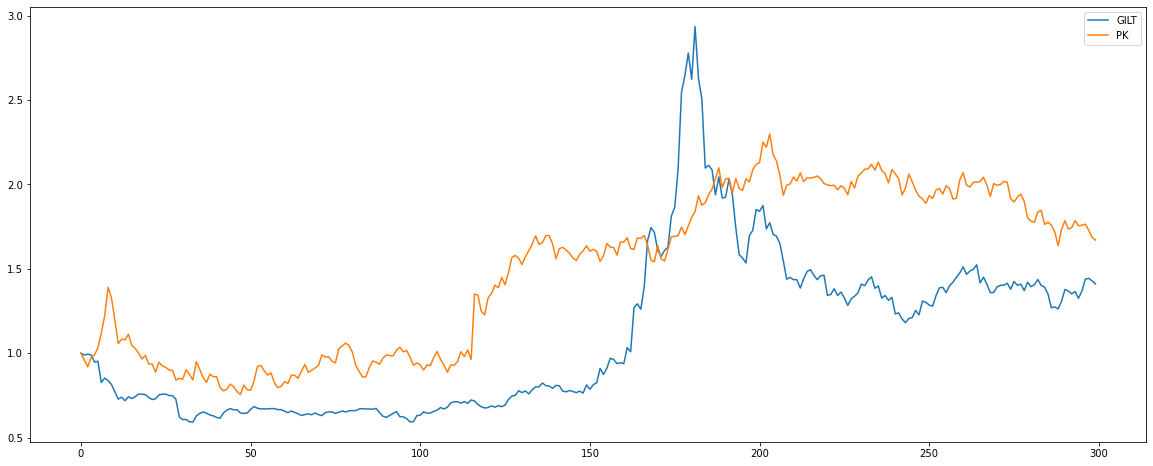

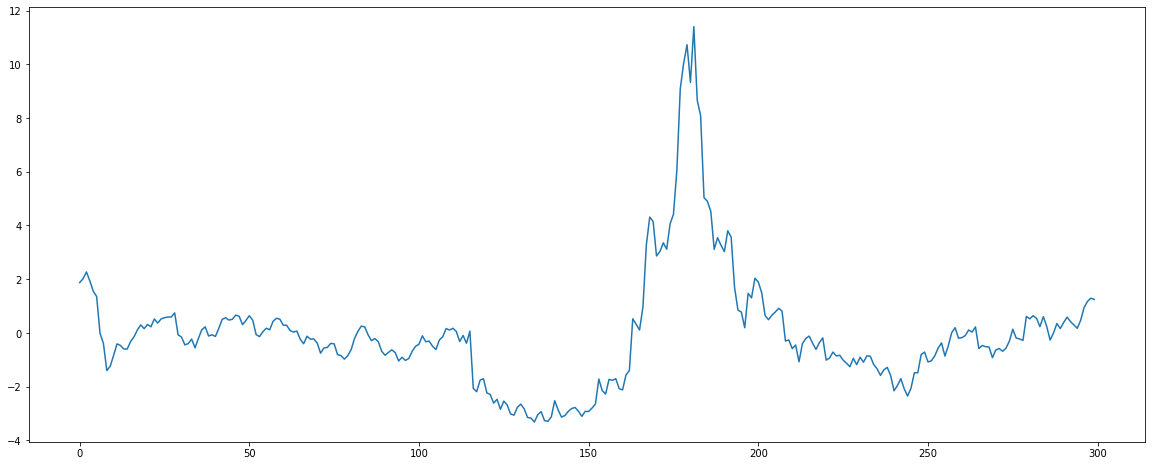

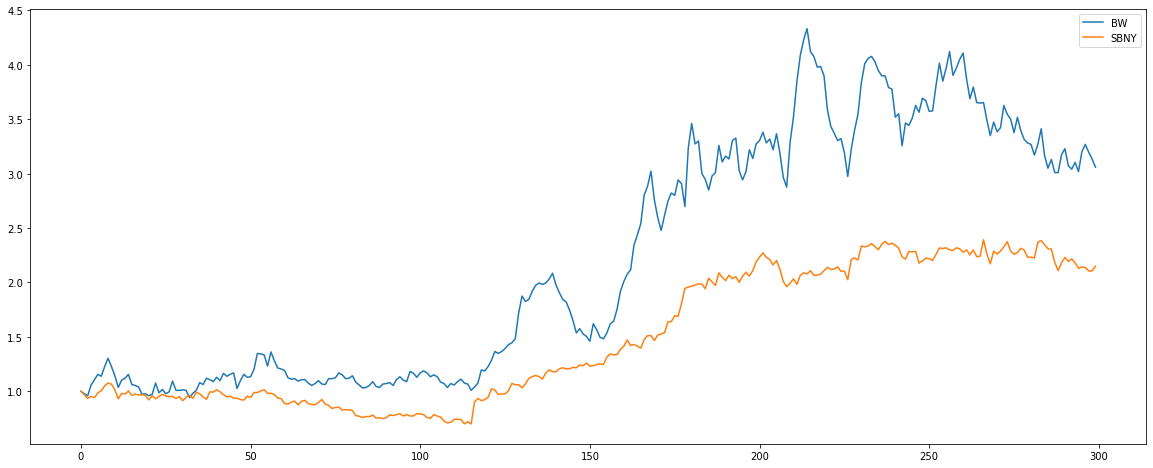

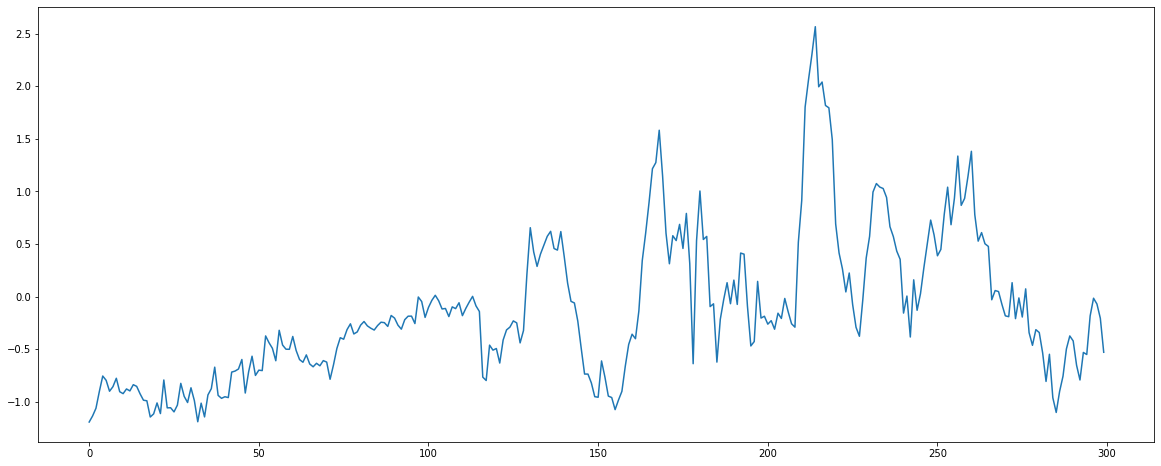

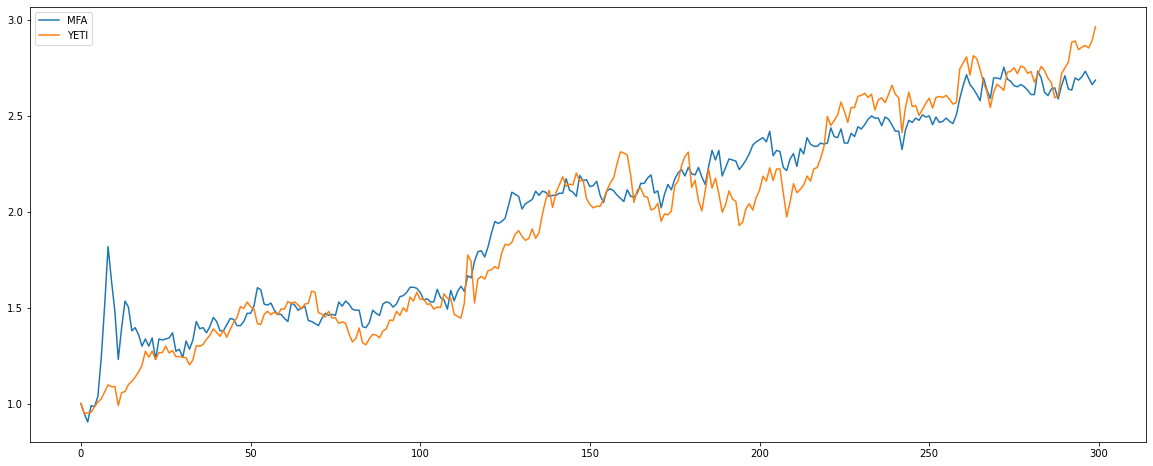

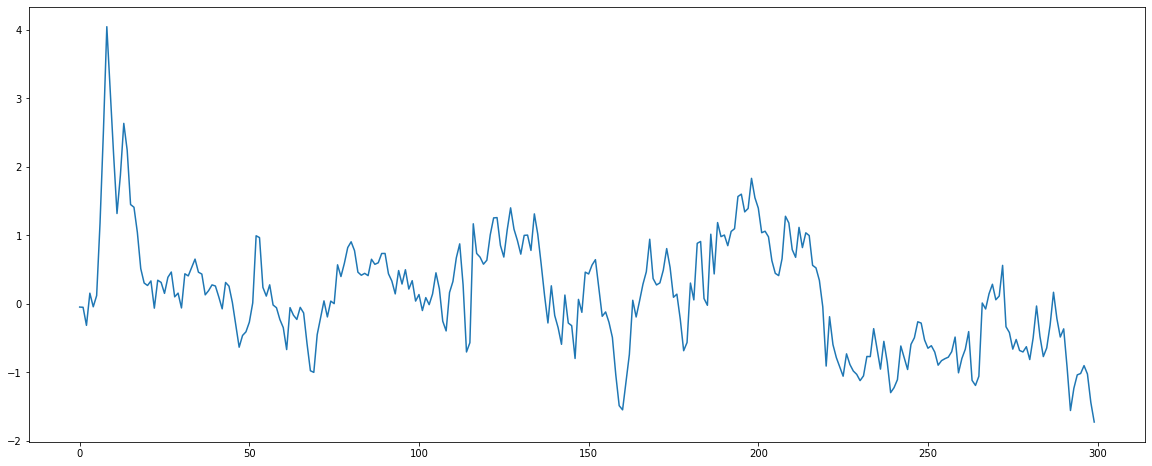

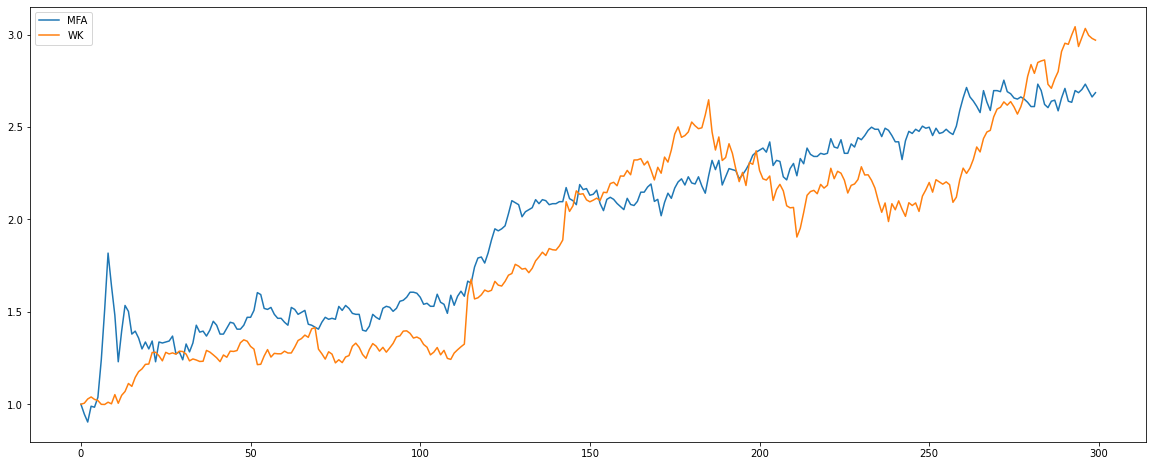

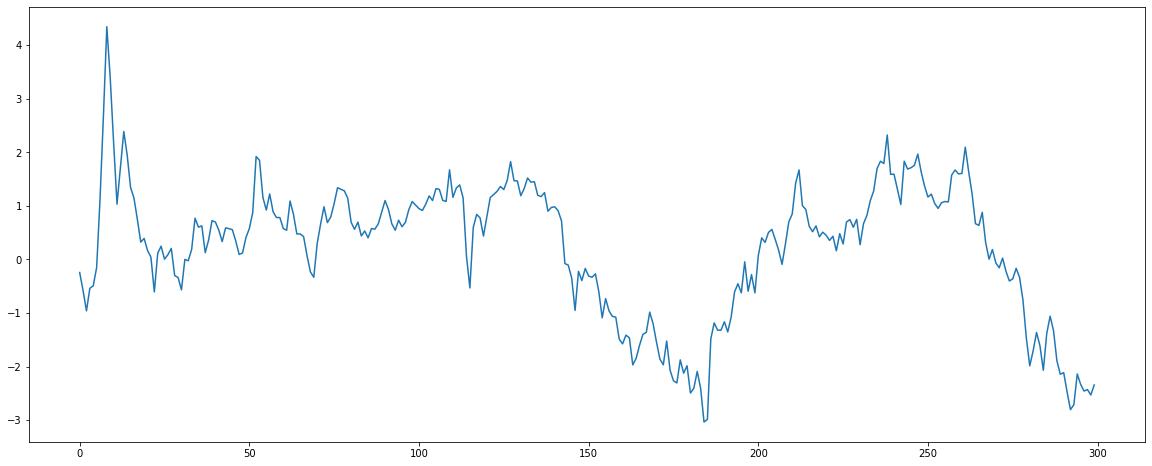

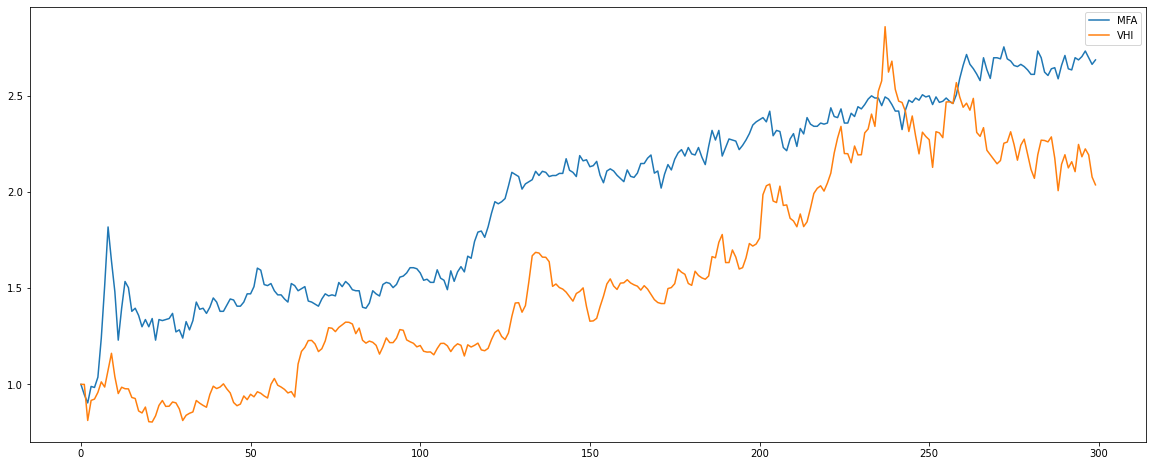

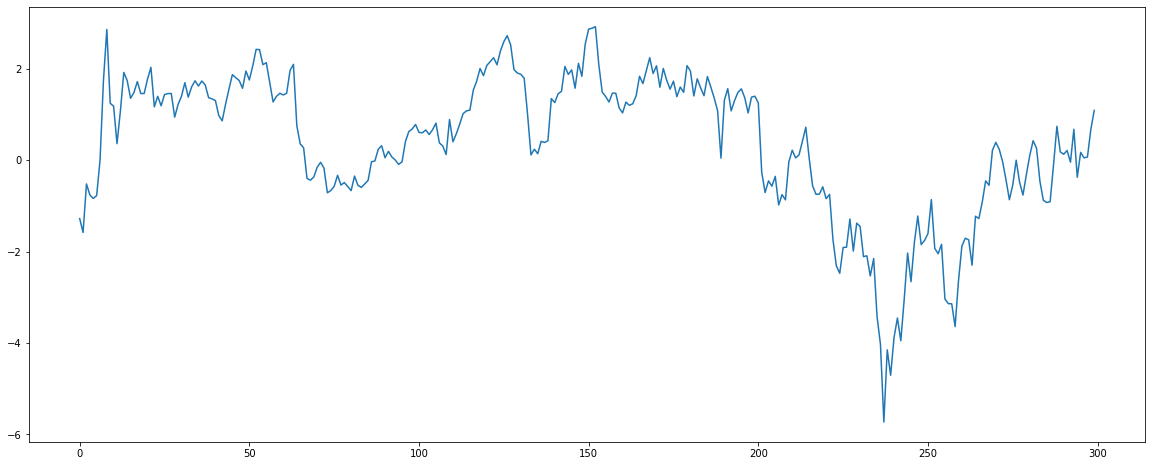

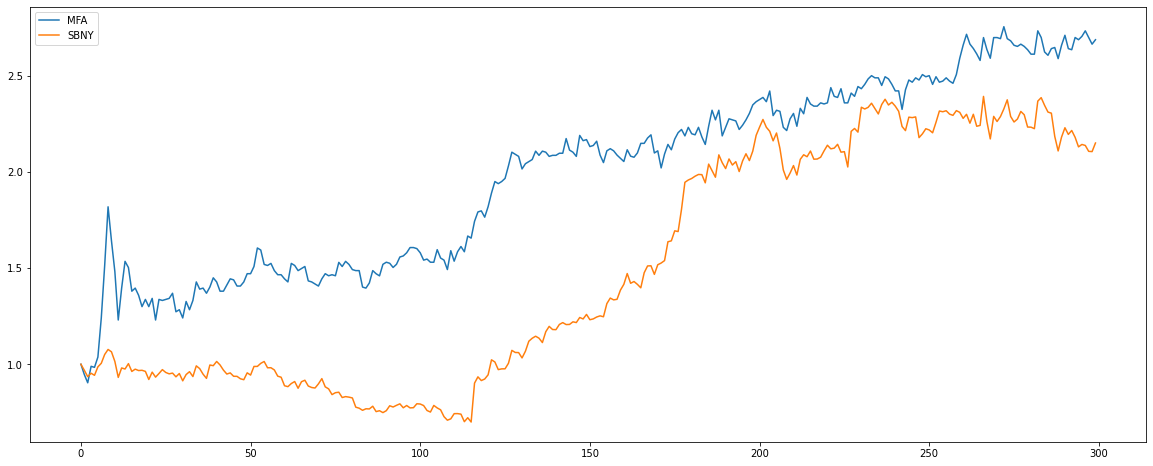

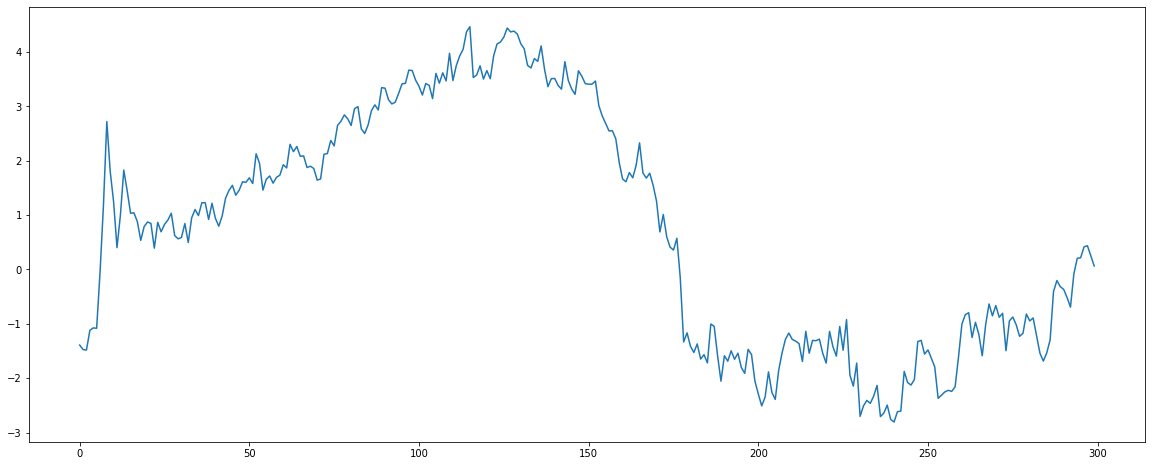

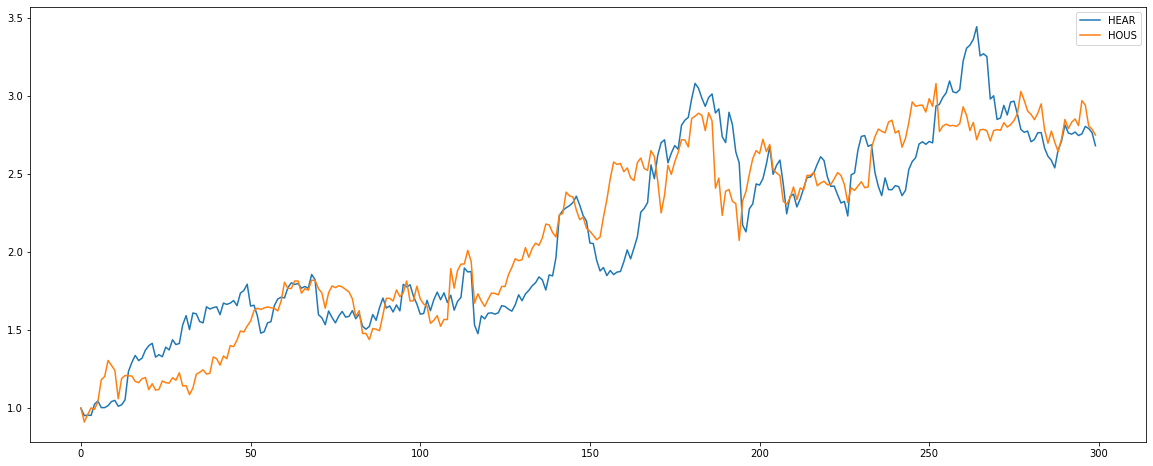

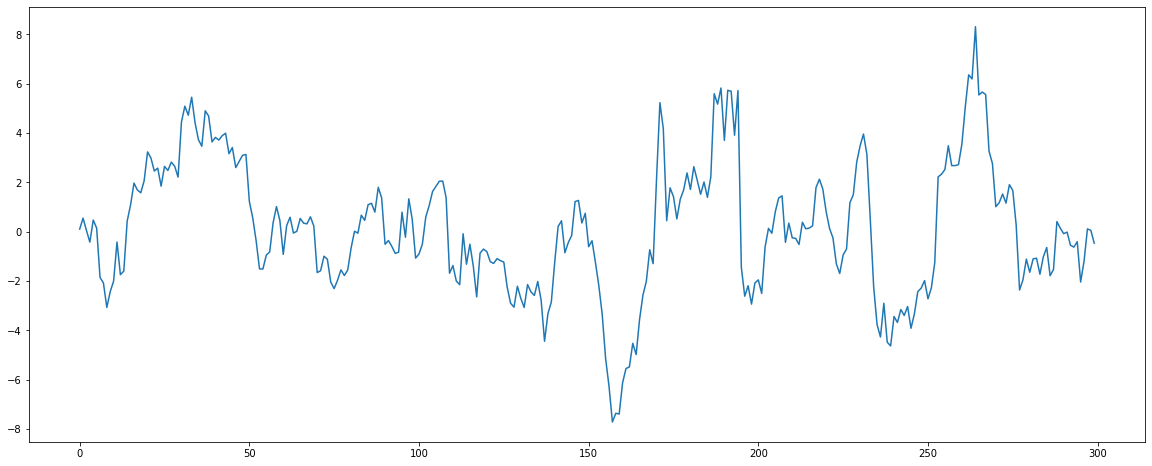

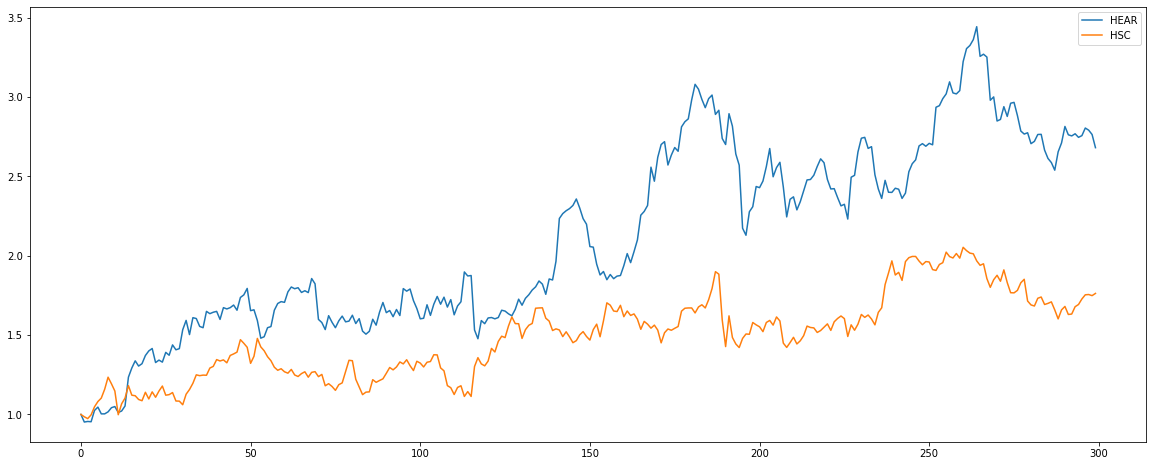

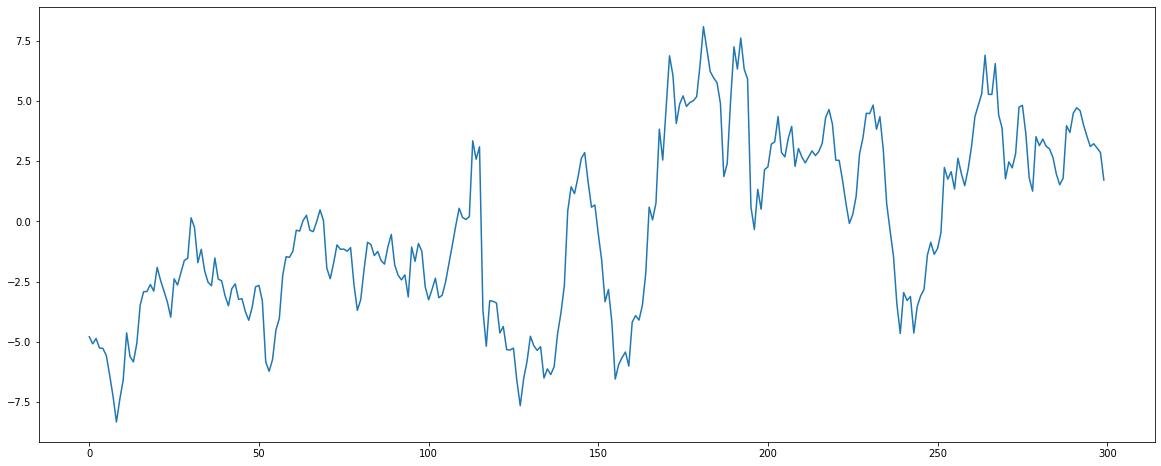

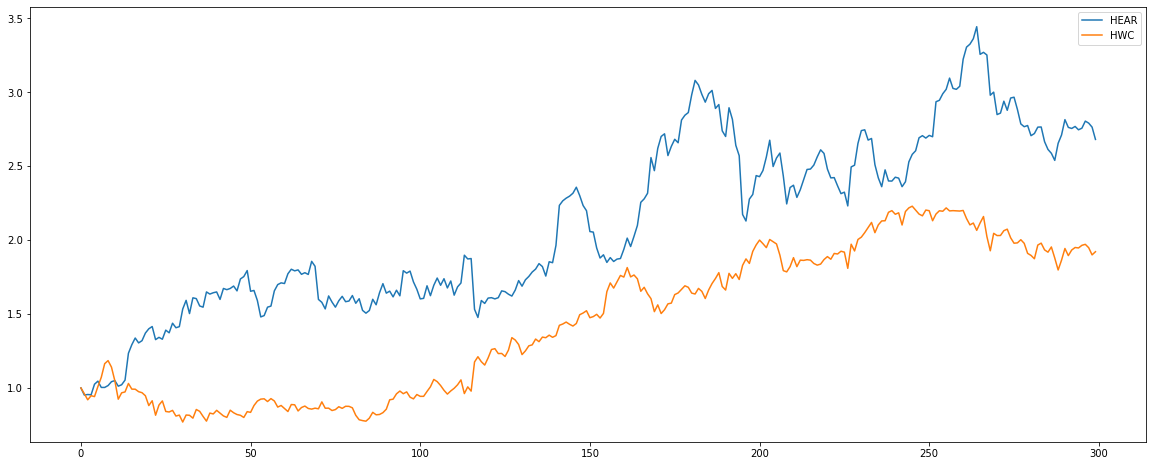

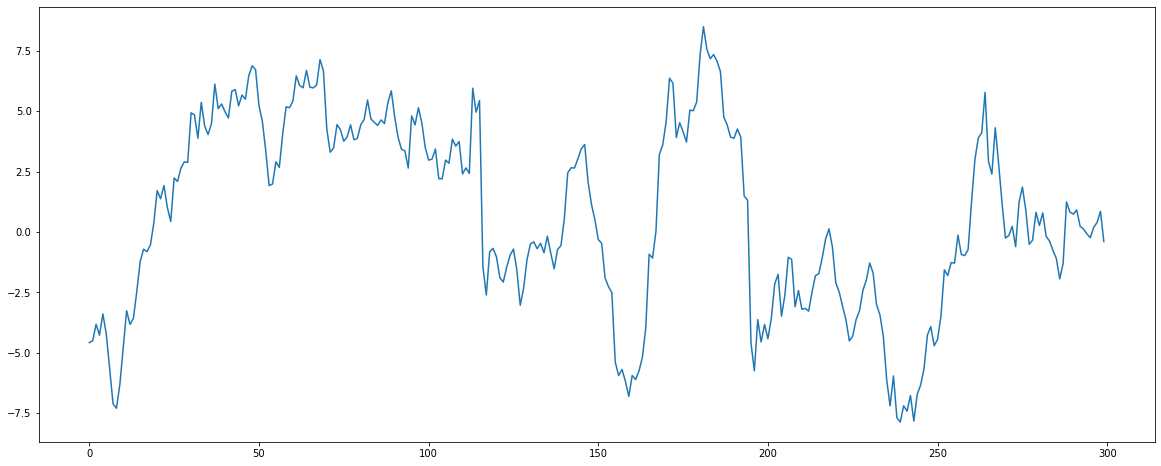

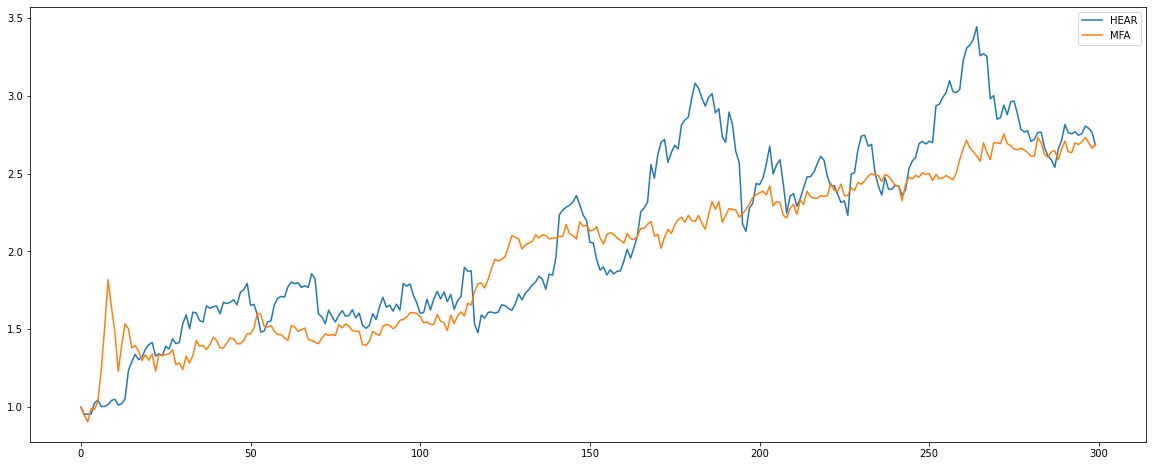

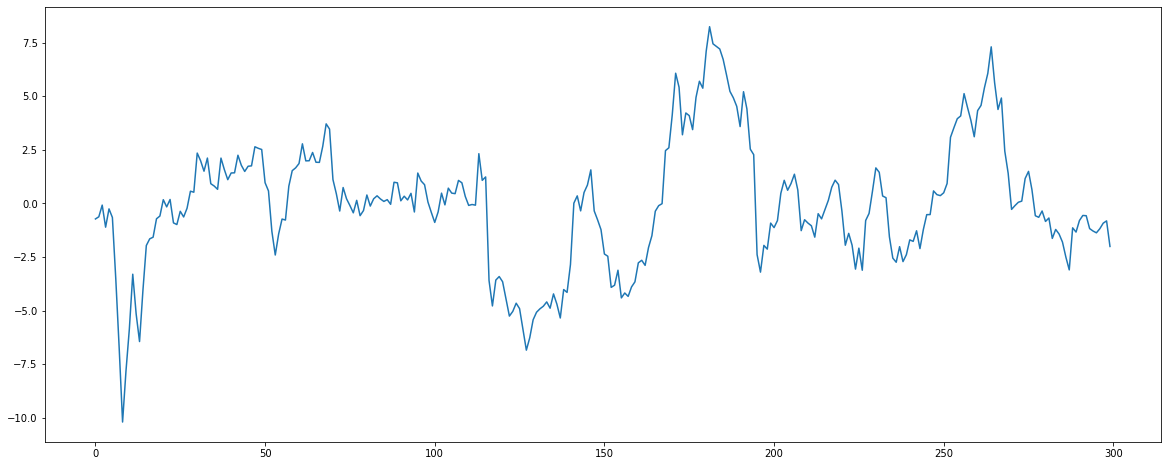

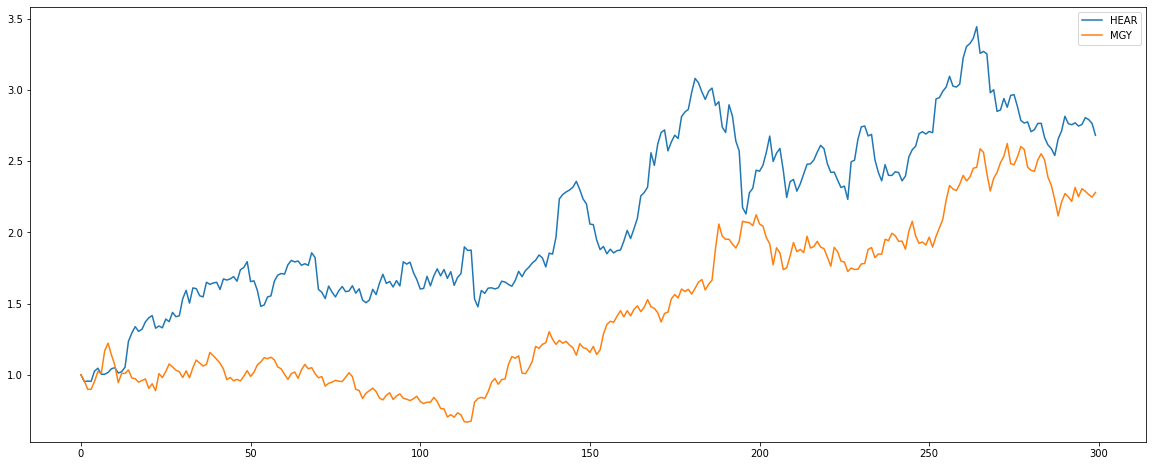

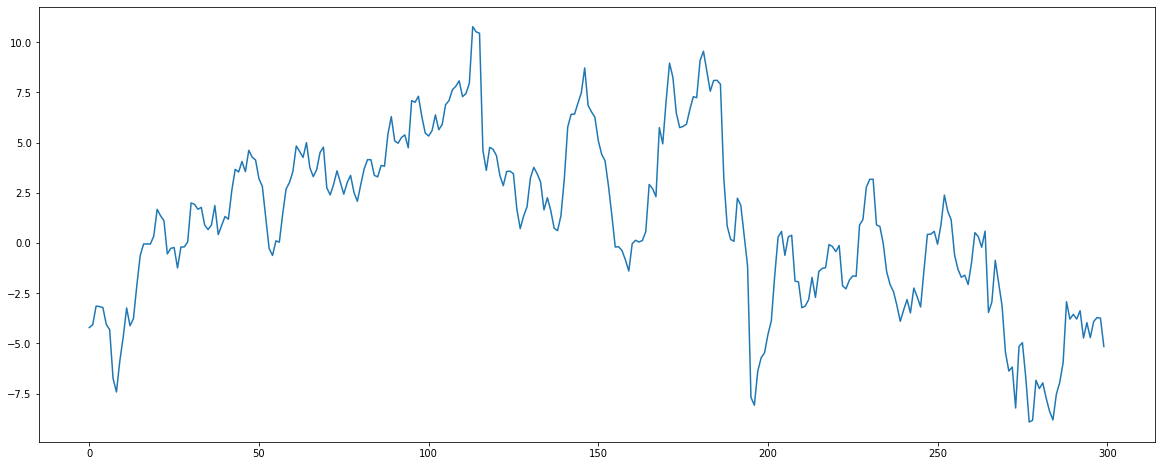

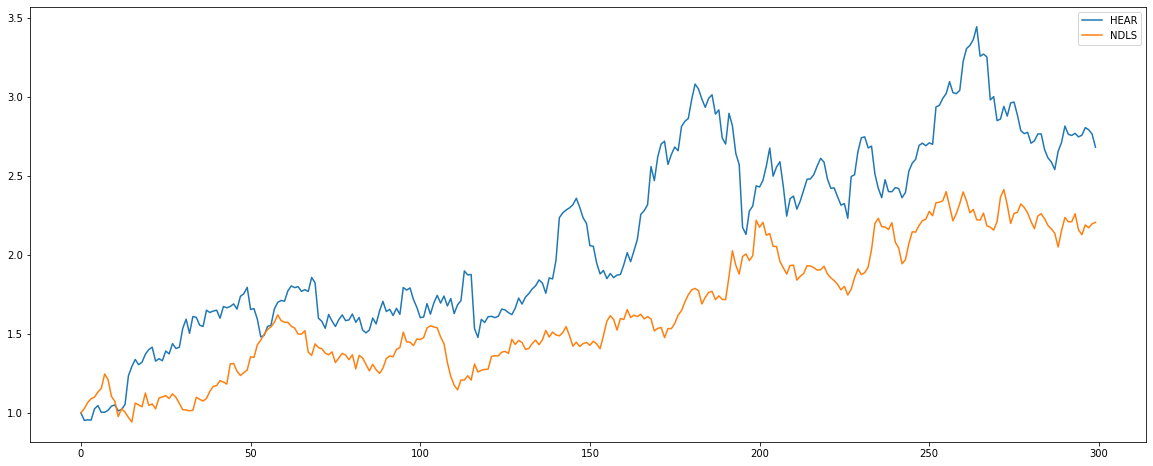

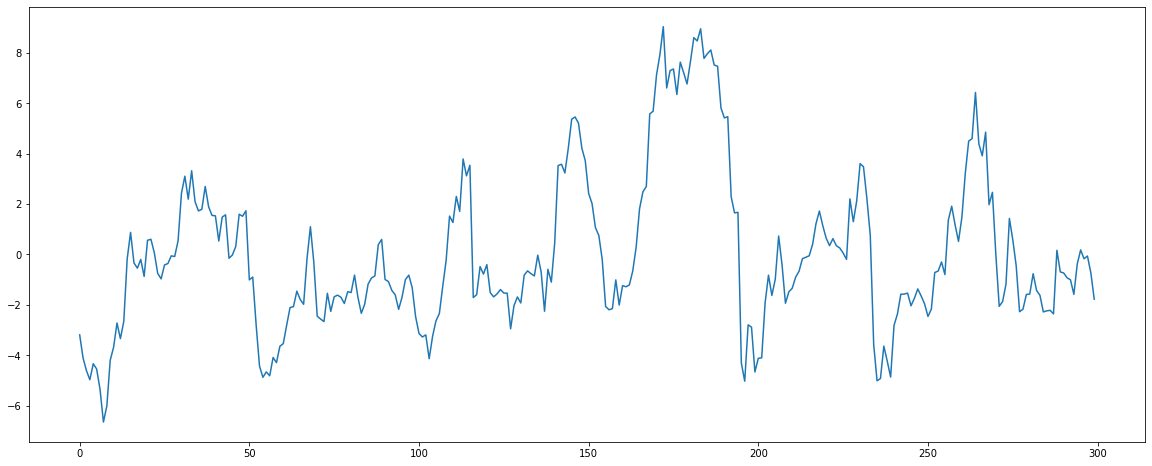

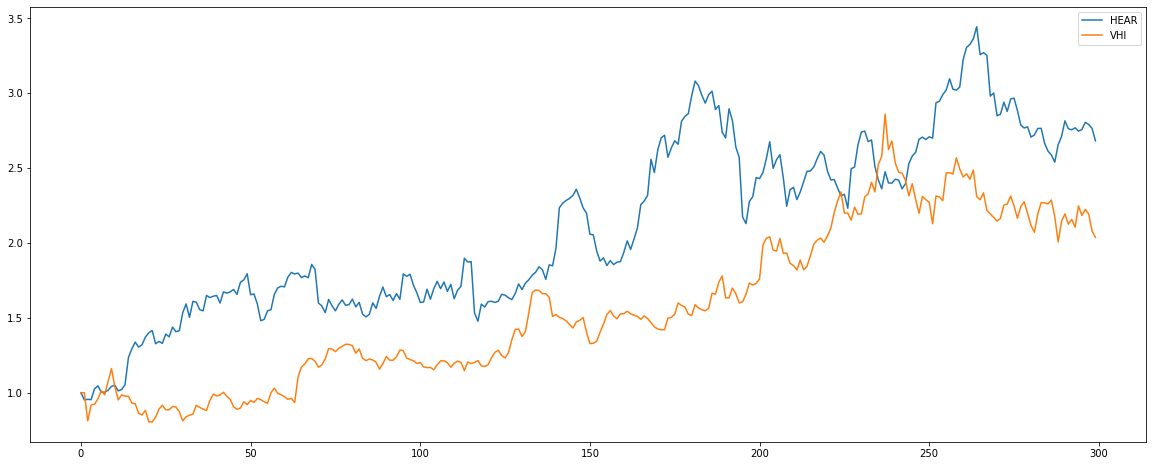

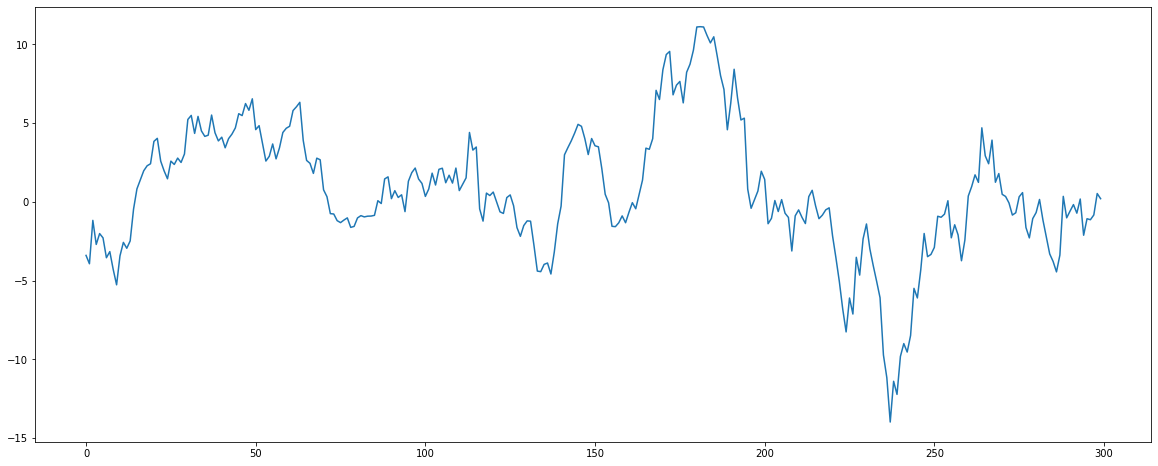

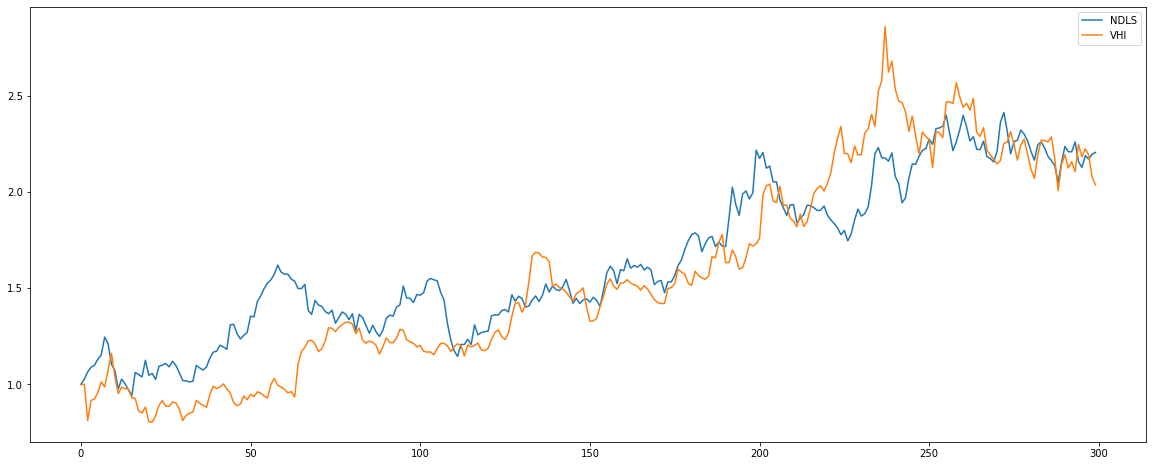

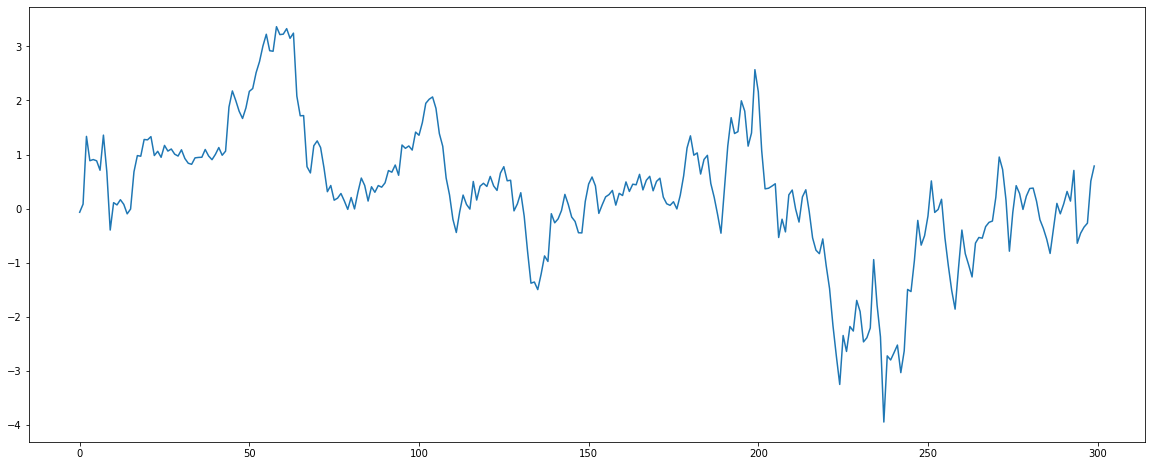

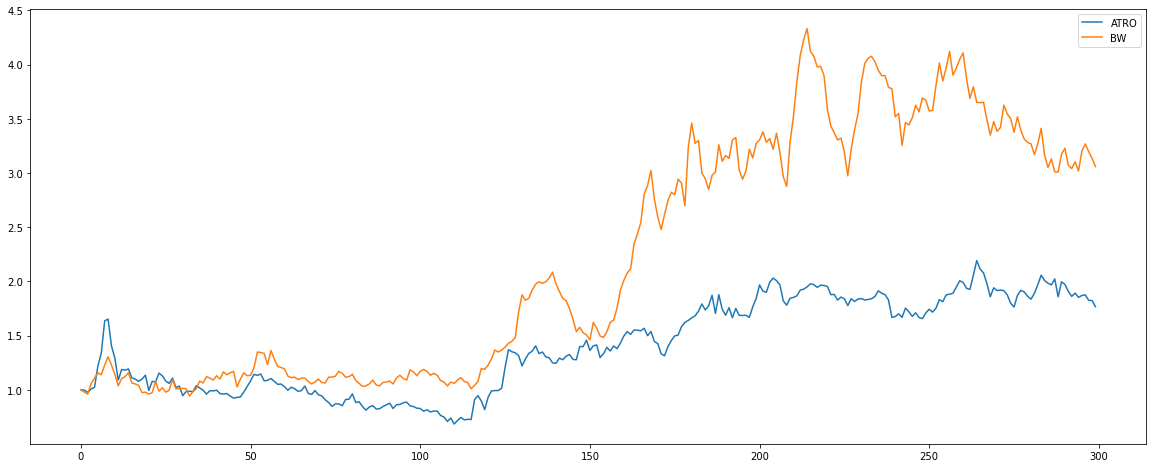

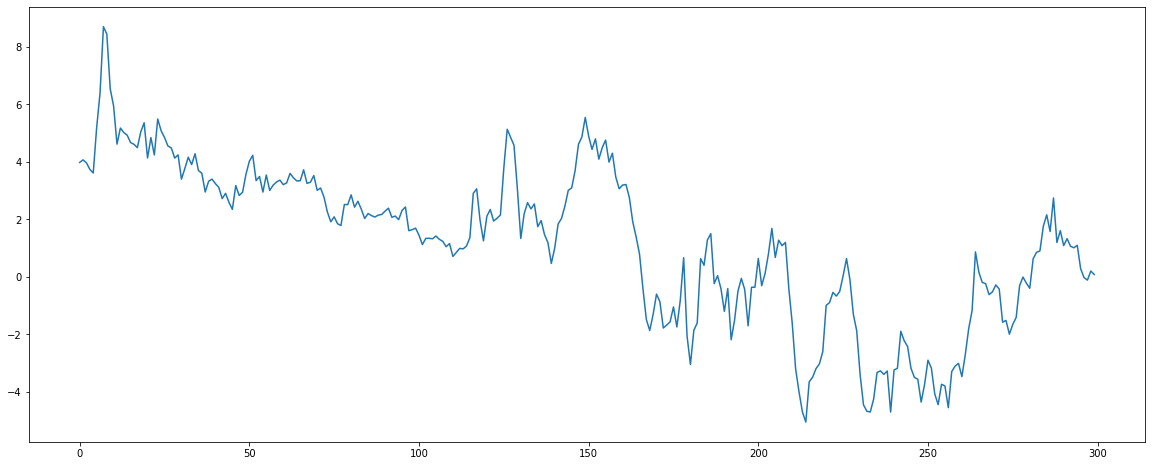

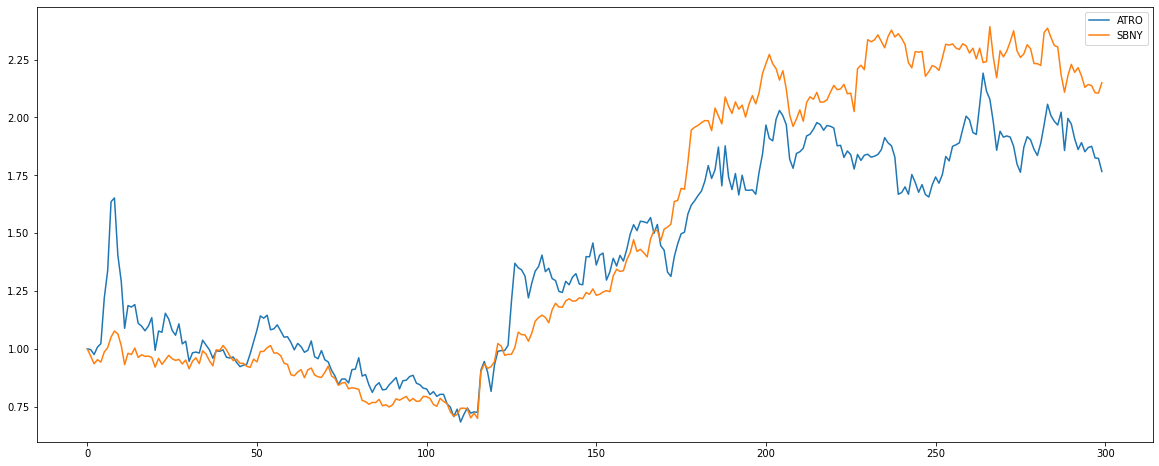

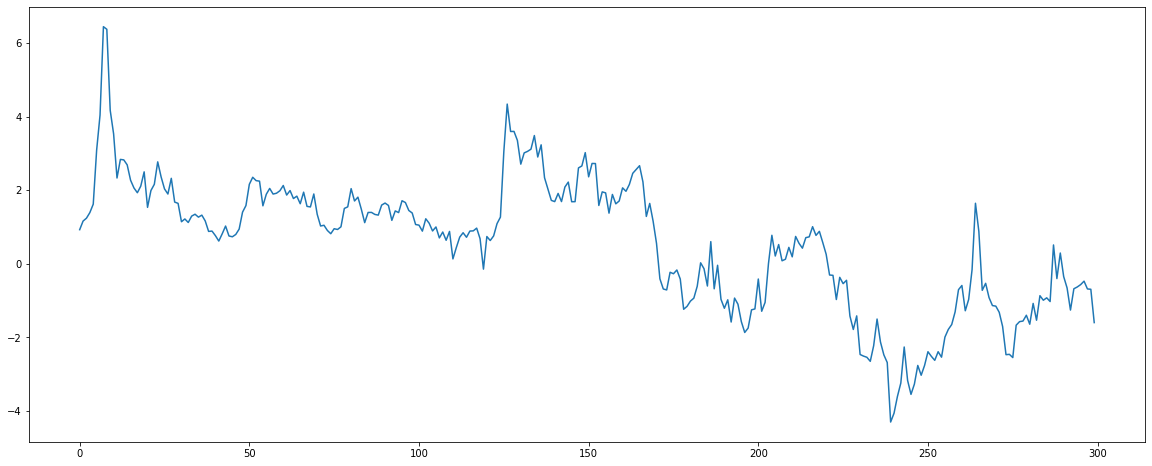

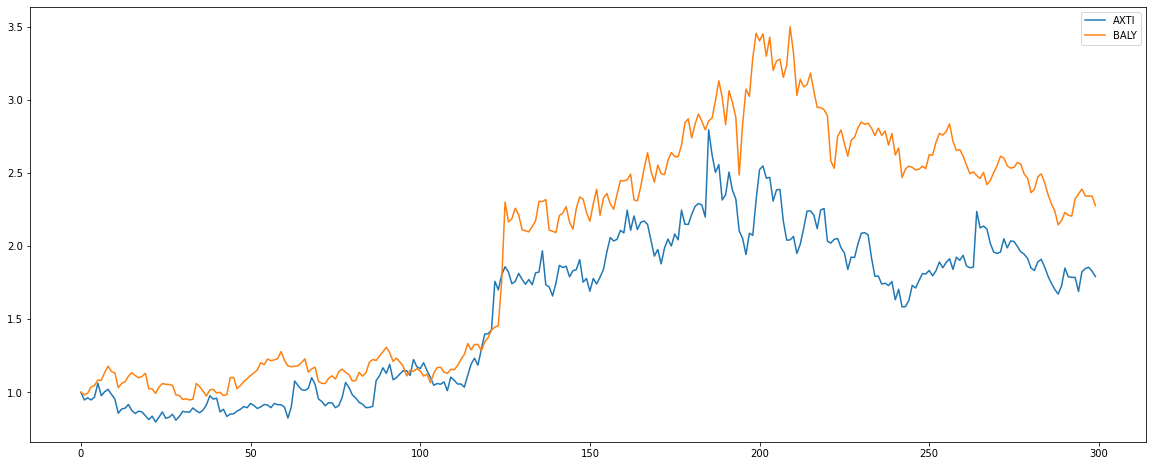

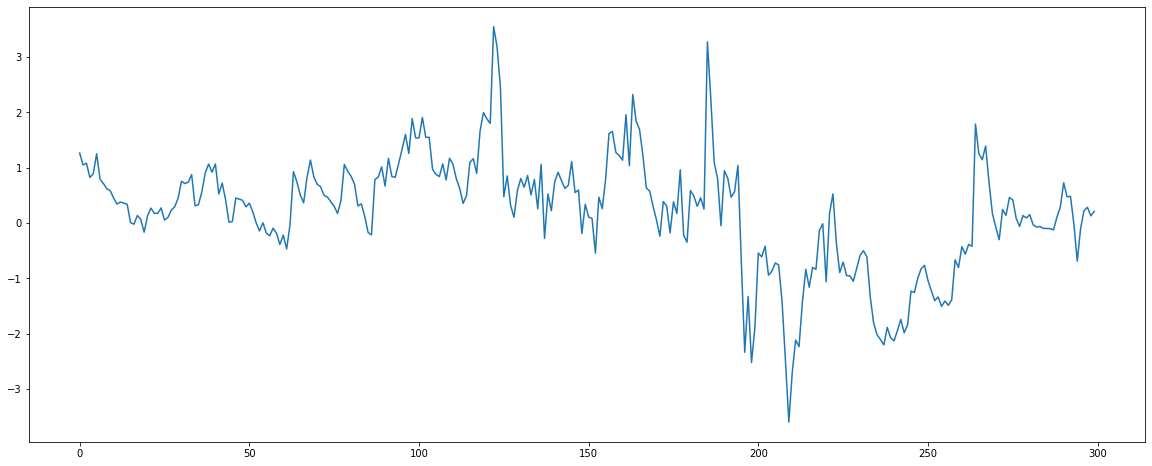

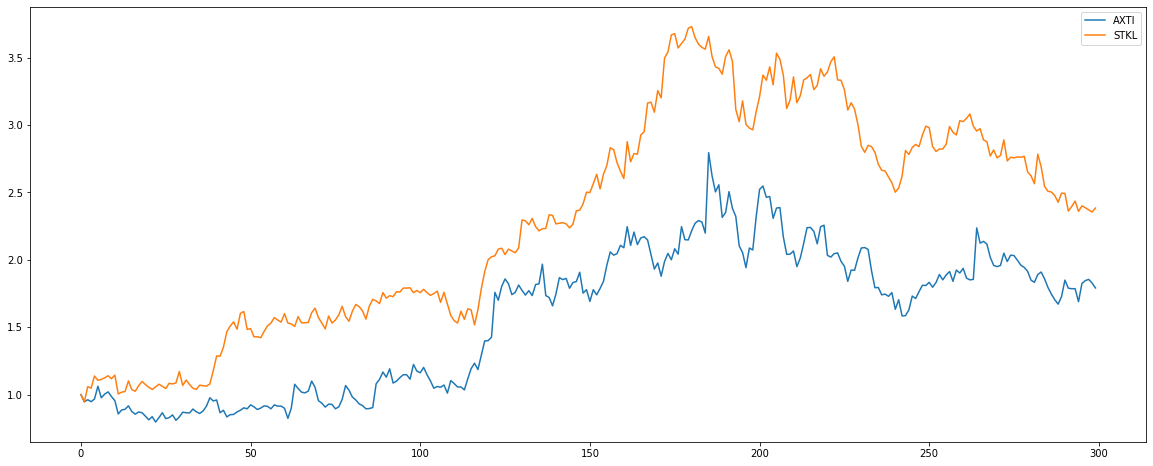

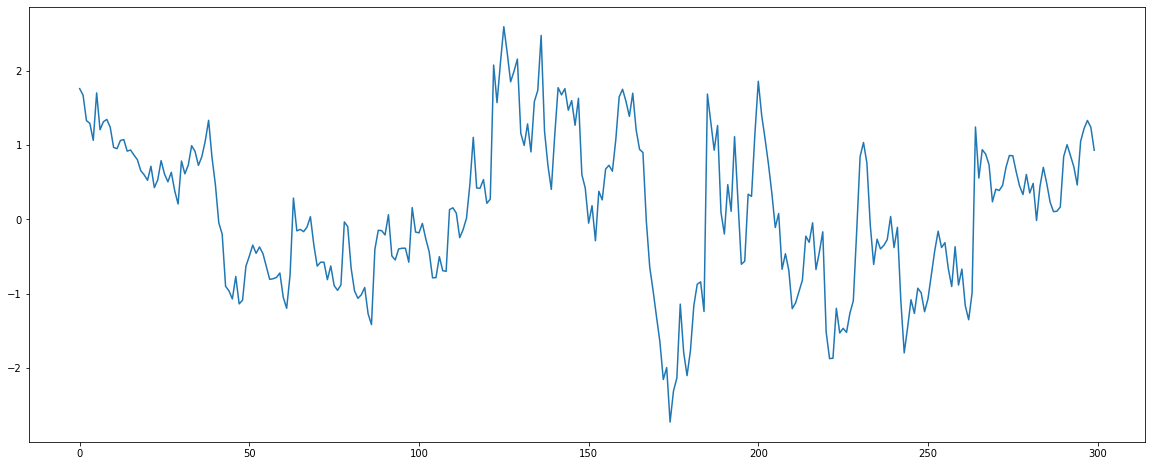

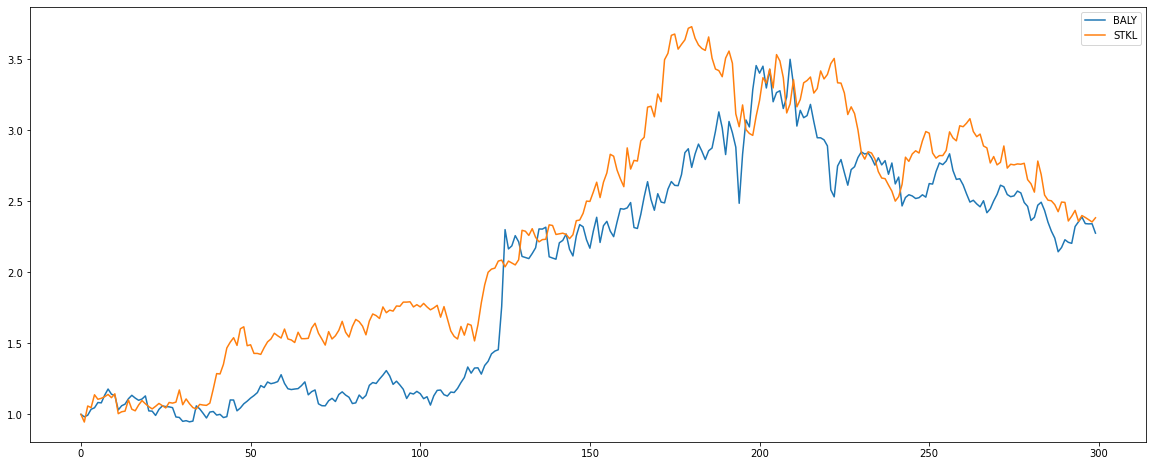

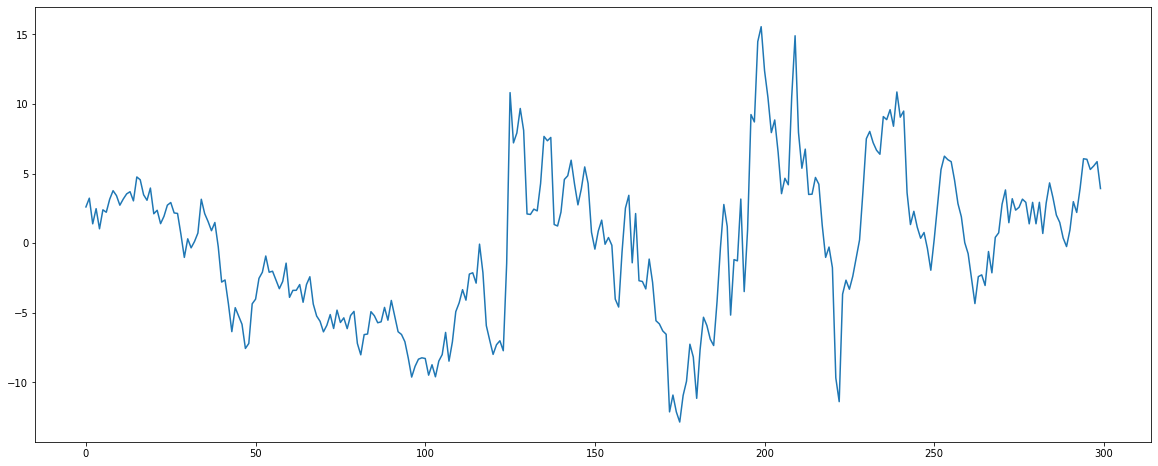

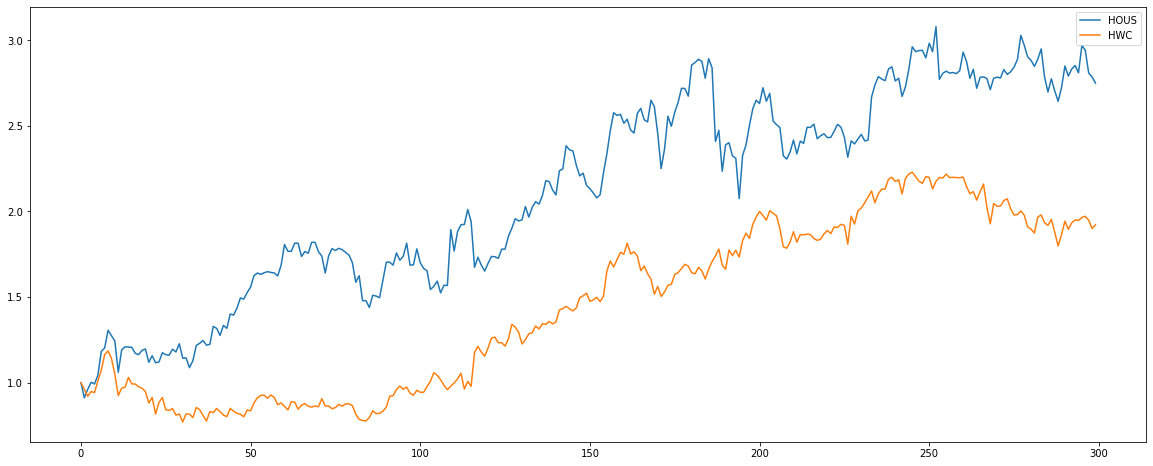

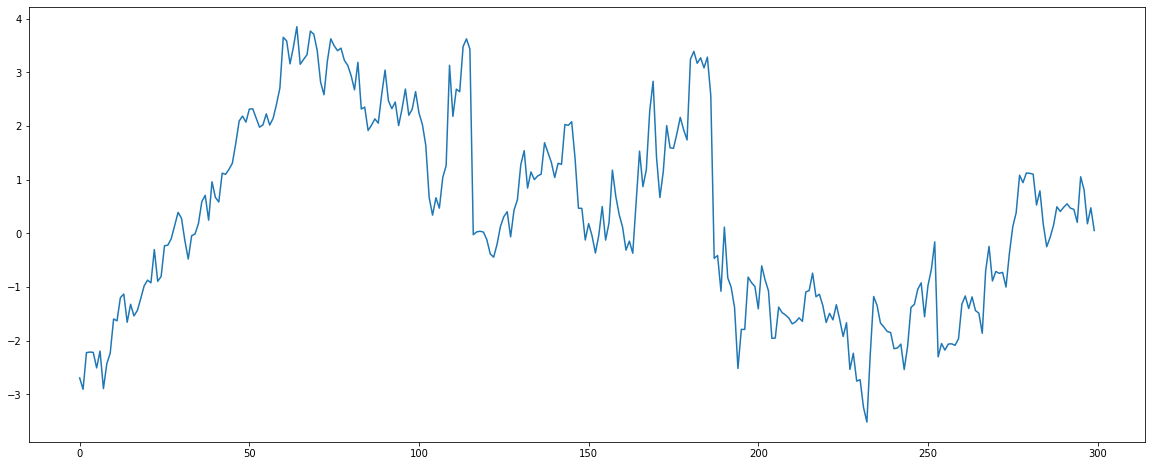

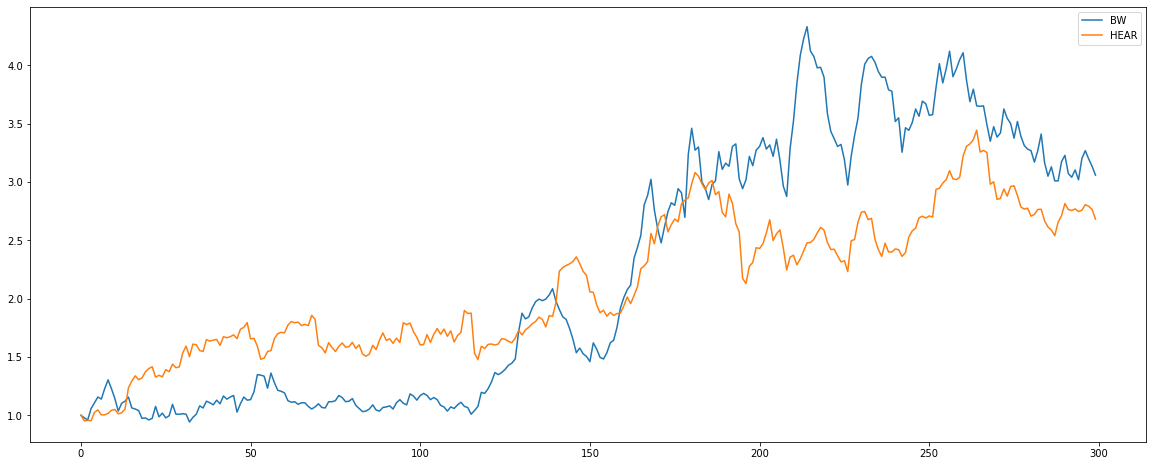

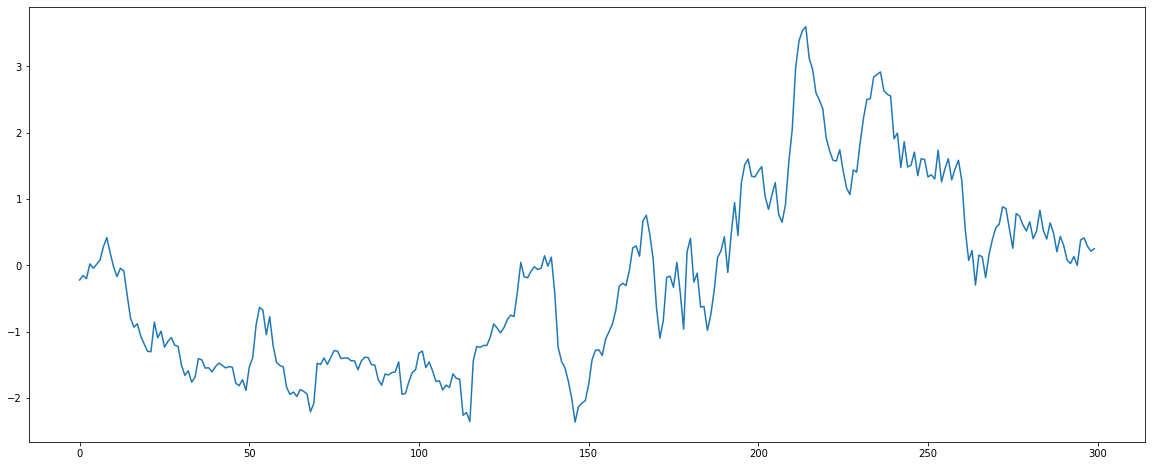

In [108]:
for i in range(len(df_coint)):
  plot_coint_assets(df_coint, i)